In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

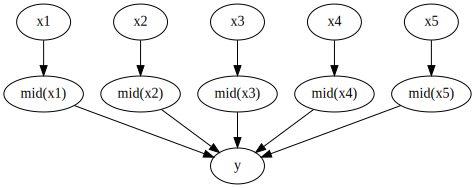

In [2]:
import dataclasses

import botorch
import networkx as nx
import torch
import math
import sysgym.params.boxes as boxes
import utils
from sysgym.params import ParamsSpace
from typing import Mapping

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}


@dataclasses.dataclass(init=False, frozen=True)
class MichalewiczSpace(ParamsSpace):
    x1: boxes.ContinuousBox = boxes.ContinuousBox(0.0, math.pi)
    x2: boxes.ContinuousBox = boxes.ContinuousBox(0.0, math.pi)
    x3: boxes.ContinuousBox = boxes.ContinuousBox(0.0, math.pi)
    x4: boxes.ContinuousBox = boxes.ContinuousBox(0.0, math.pi)
    x5: boxes.ContinuousBox = boxes.ContinuousBox(0.0, math.pi)


problem = botorch.test_functions.Michalewicz(negate=True, dim=5, noise_std=0.0001)
space = MichalewiczSpace()
dag = nx.DiGraph()
dag.add_node("y")
for i in space:
    dag.add_node(i)
    # One term
    # dag.add_edges_from([(i, f"z({i})"), (f"z({i})", "y")])
    # Both terms:
    # dag.add_edges_from([(i, f"f1({i})"), (i, f"f2({i})"),
    #                     (f"f1({i})", "y"), (f"f2({i})", "y")
    #                     ])
    dag.add_edge(i, f'mid({i})')
    dag.add_edge(f'mid({i})', 'y')



def eval_structure(x: torch.Tensor) -> torch.Tensor:
    m = 10
    return torch.sin(x) * torch.sin(problem.i * x**2 / math.pi) ** (2 * m)


utils.draw(dag)



In [3]:
from autorocks.viz import plots_setup

initial_train_x, initial_train_y = plots_setup.generate_data(10, problem)

initial_structure = eval_structure(initial_train_x)

initial_data = {
    'y': initial_train_y.tolist()
}
for idx, i in enumerate(space):
    initial_data[i] = initial_train_x[:, idx].tolist()
    initial_data[f"mid({i})"] = initial_structure[:, idx].tolist()
initial_data

{'y': [0.2130930870771408,
  0.5366595983505249,
  0.9587554931640625,
  0.8490046262741089,
  0.7814024686813354,
  0.2087351381778717,
  1.188902735710144,
  0.5117972493171692,
  0.5820977687835693,
  0.10621323436498642],
 'x1': [1.8186140060424805,
  1.2593423128128052,
  0.6220703125,
  2.3577117919921875,
  2.9683315753936768,
  0.040596358478069305,
  1.0722918510437012,
  2.0348100662231445,
  2.3400752544403076,
  0.9326964020729065],
 'mid(x1)': [0.05819357559084892,
  4.6690652766301355e-07,
  3.5814992158743084e-19,
  0.47462090849876404,
  4.2001874200892075e-11,
  0.0,
  1.0432171793084422e-09,
  0.4685956537723541,
  0.533176839351654,
  4.366846294290294e-12],
 'x2': [0.49586790800094604,
  1.689877986907959,
  0.8099740147590637,
  2.7962868213653564,
  1.1882075071334839,
  2.369180202484131,
  0.13165535032749176,
  2.103393793106079,
  1.164102554321289,
  3.129321575164795],
 'mid(x2)': [3.4210661505421227e-17,
  0.5355473160743713,
  1.0527697824613824e-08,
  0.1

In [4]:
from notebooks.bobn_ch import bench_util

num_optimization_rounds = 150
num_restarts = 3
print(torch.cuda.is_available())

True


In [7]:
import torch
import time

from notebooks.bobn_ch import bobn
bobn_opt = bobn.BoBn(dag,
                 params=space,
                 objectives={'y'})

bobn_results = []
# BO loop
for restart_id in range(num_restarts):
    print(f"{restart_id=}/{num_restarts}")
    observations = {}
    observations.update(initial_data)
    best_f = float(initial_train_y.max())
    steps_to_best_f = 0
    for optimization_round in range(num_optimization_rounds):
        bench_util.clear_memory()
        start_memory = torch.cuda.max_memory_allocated("cuda")
        start_time = time.time()

        next_candidate = bobn_opt.opt(observations)

        elapsed_time = time.time() - start_time
        total_memory_usage = torch.cuda.max_memory_allocated("cuda") - start_memory

        for k, v in next_candidate.items():
            observations[k].append(v)
        next_candidate_tensor = []
        for p in space:
            next_candidate_tensor.append(next_candidate[p])
        next_candidate_tensor = torch.tensor(next_candidate_tensor)
        y = float(problem(next_candidate_tensor))
        if y > best_f:
            best_f = y
            steps_to_best_f = optimization_round
        observations['y'].append(float(y))
        structure_eval = eval_structure(next_candidate_tensor)
        for idx, i in enumerate(space):
            observations[f"mid({i})"].append(float(structure_eval[idx]))

        exp_result = bench_util.ExperimentResult(model="BoBn", step=optimization_round, restart=restart_id,
                                             candidate=next_candidate, result=float(y), best_f=best_f,
                                             steps_to_best_f=steps_to_best_f,
                                             peak_memory=total_memory_usage, runtime_ms=elapsed_time)
        bobn_results.append(exp_result)
        print(exp_result)



group={'x5', 'mid(x5)'}
group={'mid(x1)', 'x1'}
group={'mid(x4)', 'x4'}
group={'x3', 'mid(x3)'}
group={'x2', 'mid(x2)'}
Built independent subgraph: {'x5', 'y', 'mid(x5)'}
Built independent subgraph: {'x1', 'mid(x1)', 'y'}
Built independent subgraph: {'mid(x4)', 'y', 'x4'}
Built independent subgraph: {'x3', 'mid(x3)', 'y'}
Built independent subgraph: {'x2', 'y', 'mid(x2)'}
restart_id=0/3
ExperimentResult(model='BoBn', step=0, restart=0, candidate={'x5': 0.9965815271862424, 'x1': 2.2032312591602126, 'x4': 1.1138853241022653, 'x3': 1.2851076120751022, 'x2': 1.5708249919144317}, result=4.495931625366211, best_f=4.495931625366211, steps_to_best_f=0, peak_memory=152654848, runtime_ms=14.052942991256714)
ExperimentResult(model='BoBn', step=1, restart=0, candidate={'x5': 0.9965818213766389, 'x1': 2.203242494199788, 'x4': 1.1138845923835656, 'x3': 1.2851073550945915, 'x2': 1.5708251030427913}, result=4.495838165283203, best_f=4.495931625366211, steps_to_best_f=0, peak_memory=152152576, runtime_

In [5]:
import torch
import time
from notebooks.bobn_ch import bobn

con_bobn = bobn.BoBn(dag,
                 params=space,
                 objectives={'y'},
                     conservative_mode=True)

con_bobn_results = []

# BO loop
for restart_id in range(num_restarts):
    print(f"{restart_id=}/{num_restarts}")
    observations = {}
    observations.update(initial_data)
    best_f = float(initial_train_y.max())
    steps_to_best_f = 0
    for optimization_round in range(num_optimization_rounds):
        bench_util.clear_memory()
        start_memory = torch.cuda.max_memory_allocated("cuda")
        start_time = time.time()

        next_candidate = con_bobn.opt(observations)

        elapsed_time = time.time() - start_time
        total_memory_usage = torch.cuda.max_memory_allocated("cuda") - start_memory


        for k, v in next_candidate.items():
            observations[k].append(v)
        next_candidate_tensor = []
        for p in space:
            next_candidate_tensor.append(next_candidate[p])
        next_candidate_tensor = torch.tensor(next_candidate_tensor)
        y = float(problem(next_candidate_tensor))
        if y > best_f:
            best_f = y
            steps_to_best_f = optimization_round
        observations['y'].append(float(y))
        structure_eval = eval_structure(next_candidate_tensor)
        for idx, i in enumerate(space):
            observations[f"mid({i})"].append(float(structure_eval[idx]))

        exp_result = bench_util.ExperimentResult(model="Conservative BoBn", step=optimization_round, restart=restart_id,
                                             candidate=next_candidate, result=float(y), best_f=best_f,
                                             steps_to_best_f=steps_to_best_f,
                                             peak_memory=total_memory_usage, runtime_ms=elapsed_time)
        con_bobn_results.append(exp_result)
        print(exp_result)



group={'x5', 'mid(x5)'}
group={'mid(x1)', 'x1'}
group={'mid(x4)', 'x4'}
group={'x3', 'mid(x3)'}
group={'x2', 'mid(x2)'}
Built independent subgraph: {'x5', 'y', 'mid(x5)'}
Built independent subgraph: {'x1', 'mid(x1)', 'y'}
Built independent subgraph: {'mid(x4)', 'y', 'x4'}
Built independent subgraph: {'x3', 'mid(x3)', 'y'}
Built independent subgraph: {'x2', 'y', 'mid(x2)'}
restart_id=0/3
ExperimentResult(model='Conservative BoBn', step=0, restart=0, candidate={'x5': 2.130097073586063, 'x1': 2.2040625224190054, 'x4': 2.2957796699487125, 'x3': 1.464208441053007, 'x2': 1.7456519402055537}, result=1.1504356861114502, best_f=1.188902735710144, steps_to_best_f=0, peak_memory=34321920, runtime_ms=7.2810211181640625)
ExperimentResult(model='Conservative BoBn', step=1, restart=0, candidate={'x5': 2.104105881450225, 'x1': 2.201012920159125, 'x4': 1.0479401985305916, 'x3': 1.4799708890931538, 'x2': 1.666527281852298}, result=2.17467999458313, best_f=2.17467999458313, steps_to_best_f=1, peak_memory

In [6]:
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
botorch_results = []
import time

for restart_id in range(num_restarts):
    print(f"{restart_id=}/{num_restarts}")
    train_x = initial_train_x.clone().to(**tkwargs)
    train_y = initial_train_y.clone().to(**tkwargs)
    best_f = float(initial_train_y.max())
    steps_to_best_f = 0
    for optimization_round in range(num_optimization_rounds):
        bench_util.clear_memory()
        start_memory = torch.cuda.max_memory_allocated("cuda")
        start_time = time.time()

        next_candidate = bench_util.botorch_optimize(train_x, train_y, problem, tkwargs)

        elapsed_time = time.time() - start_time
        total_memory_usage = torch.cuda.max_memory_allocated("cuda") - start_memory

        y = problem(next_candidate)
        if float(y) > best_f:
            best_f = float(y)
            steps_to_best_f = optimization_round
        # print(f"{y=}")
        train_y = torch.concat([train_y, y])
        train_x = torch.concat([train_x, next_candidate])
        res = bench_util.ExperimentResult(
            model="BoTorch",
            step=optimization_round,
            restart=restart_id,
            candidate=next_candidate.squeeze().detach().cpu().tolist(),
            result=float(y),
            best_f=best_f,
            steps_to_best_f=steps_to_best_f,
            peak_memory=torch.cuda.max_memory_allocated(), runtime_ms=elapsed_time
        )
        print(res)
        botorch_results.append(res)




restart_id=0/3
ExperimentResult(model='BoTorch', step=0, restart=0, candidate=[0.9548369248201807, 0.0, 2.065155269767753, 0.9214143819925033, 0.5907162583627741], result=0.07606828666808865, best_f=1.188902735710144, steps_to_best_f=0, peak_memory=37479424, runtime_ms=0.44219446182250977)
ExperimentResult(model='BoTorch', step=1, restart=0, candidate=[1.417827164816408, 0.0, 2.380239928820452, 0.0, 1.5686068937341204], result=0.004320668458859507, best_f=1.188902735710144, steps_to_best_f=0, peak_memory=37483520, runtime_ms=0.19492626190185547)
ExperimentResult(model='BoTorch', step=2, restart=0, candidate=[3.1415927410125732, 2.409471734011534, 2.604503000918029, 1.2402347367152768, 1.6214544741889747], result=0.25569819765661306, best_f=1.188902735710144, steps_to_best_f=0, peak_memory=37487104, runtime_ms=0.2997899055480957)
ExperimentResult(model='BoTorch', step=3, restart=0, candidate=[1.2400657181063632, 0.7495711711109659, 1.8202657264367403, 3.1415927410125732, 0.0], result=5.

/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=4, restart=0, candidate=[1.906367164663103, 0.2502891660444717, 2.251786949732557, 2.4155918577882862, 1.0767241824282558], result=1.3322838913497606, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37494784, runtime_ms=0.09421992301940918)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=5, restart=0, candidate=[0.9124766187561117, 2.480831039523154, 3.000323960784125, 3.0934995769952778, 0.5051249996824159], result=0.0007270357936605746, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37496832, runtime_ms=0.0934743881225586)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=6, restart=0, candidate=[0.3829024946634829, 0.05310821703107704, 0.9591470246816602, 3.128612022763777, 1.0300361483393616], result=0.7503672101002388, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37498880, runtime_ms=0.09382343292236328)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=7, restart=0, candidate=[1.542346729724332, 0.874796072893046, 1.3362180819486724, 0.4750574270506558, 2.669931051205352], result=0.9424518696544059, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37502464, runtime_ms=0.10085391998291016)
ExperimentResult(model='BoTorch', step=8, restart=0, candidate=[2.052689148124513, 0.0, 2.4742593418073855, 2.2216913819274846, 1.3901150309346166], result=0.5206964771802596, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37506048, runtime_ms=0.11807394027709961)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=9, restart=0, candidate=[1.4897735603664553, 2.1685955829175785, 0.9476228813398724, 0.9006520915109129, 2.3895328709846178], result=0.040673142892265056, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37508096, runtime_ms=0.09583520889282227)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=10, restart=0, candidate=[0.11606775394043867, 1.9301459156223455, 1.0056566939416944, 2.683592514994589, 1.6166267834765258], result=0.05723898009574132, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37511680, runtime_ms=0.1012125015258789)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=11, restart=0, candidate=[1.399985734827509, 1.411345598316096, 3.031369055303653, 0.11413932064550436, 0.37836572517401024], result=0.3892026575468357, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37513728, runtime_ms=0.0952751636505127)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=12, restart=0, candidate=[0.10508595238159724, 3.0566752156652734, 3.0193435728479856, 0.3555423767805621, 0.3389643399489073], result=1.1902608158702545e-05, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37517312, runtime_ms=0.09812641143798828)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=13, restart=0, candidate=[2.8991398977604566, 2.0553028676172858, 1.7417246248019103, 1.8979141809214706, 1.1804423151451837], result=0.817602361227248, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37520896, runtime_ms=0.12113690376281738)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=14, restart=0, candidate=[0.38045087503546515, 0.8937358739959533, 1.7072632858527415, 3.0688897568812576, 3.122550187466755], result=8.593806483133192e-05, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37522944, runtime_ms=0.11763739585876465)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=15, restart=0, candidate=[0.47162957875448774, 2.163973838366189, 0.95802008618879, 1.5492656419344686, 2.290165190505402], result=0.0635809683699477, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37526528, runtime_ms=0.12185955047607422)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=16, restart=0, candidate=[1.4906295986077045, 2.2178278217964675, 1.7623978375851779, 0.7198079031694815, 2.0949658518606027], result=0.0004467673149081246, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37531136, runtime_ms=0.11211252212524414)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=17, restart=0, candidate=[3.134152026389895, 2.095986011959896, 2.7979967028173878, 0.8088036316923664, 1.2459570462854574], result=0.07955650847005262, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37534720, runtime_ms=0.11803722381591797)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=18, restart=0, candidate=[1.8080307858675826, 1.782376193519819, 3.0822558311695456, 1.9968829002226784, 1.198393610771078], result=0.40564006135200037, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37538304, runtime_ms=0.11712980270385742)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=19, restart=0, candidate=[0.48420960958189485, 1.785201214220452, 2.545921887212328, 2.371766128331231, 0.6303313807547939], result=0.11463924012517646, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37541888, runtime_ms=0.1109158992767334)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=20, restart=0, candidate=[0.9635098912425388, 0.1481645519997632, 0.7584280813410083, 2.7323889681205547, 2.8610216409442213], result=-8.051277901524687e-05, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37545472, runtime_ms=0.10007071495056152)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=21, restart=0, candidate=[2.5928004078696243, 0.9982371214116859, 0.8472751042369975, 1.0779715629699438, 2.398752450153644], result=0.8274522568087902, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37549056, runtime_ms=0.10846090316772461)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=22, restart=0, candidate=[0.17787648631072073, 1.2565750815504217, 1.1889932500324574, 3.0603053153173643, 1.0685655407381989], result=1.0743299417149679, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37551104, runtime_ms=0.10935854911804199)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=23, restart=0, candidate=[1.9041675473104325, 2.5467181681742126, 2.568667537098588, 0.7632105245220411, 1.014658184203231], result=0.9844202836595817, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37556224, runtime_ms=0.11214876174926758)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=24, restart=0, candidate=[0.5993135316223319, 1.581482469499701, 0.32607742986163646, 1.3981311145292363, 1.8633305390916355], result=0.9958910882320158, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37559808, runtime_ms=0.11378836631774902)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=25, restart=0, candidate=[1.87448401116602, 1.824931832094292, 0.8388867785504317, 0.41457375032255994, 0.7125922175378541], result=0.15548079659849134, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37563392, runtime_ms=0.11167478561401367)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=26, restart=0, candidate=[1.9495317429050163, 2.5656747430962836, 2.4635497603962087, 0.6013165532605314, 1.4851778352767475], result=0.27647141999138264, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37566976, runtime_ms=0.11565899848937988)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=27, restart=0, candidate=[2.533708168156327, 0.27767870906245773, 1.1610318757280624, 1.55724314510291, 0.015253601466751476], result=0.46198169511203924, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37570560, runtime_ms=0.11752629280090332)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=28, restart=0, candidate=[2.402953895403328, 2.7897617640957018, 2.745282417451822, 0.6414428027107377, 2.9836163854787823], result=0.6769795610002101, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37574144, runtime_ms=0.11504626274108887)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=29, restart=0, candidate=[2.1229680210996915, 0.16309736770700245, 2.889496511212073, 0.2767018484136796, 1.4008840484765894], result=0.9233988212535402, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37578752, runtime_ms=0.13645339012145996)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=30, restart=0, candidate=[1.8842352879257518, 0.6193480167994003, 1.2027349548805755, 0.6228290216883758, 0.84718553853802], result=0.8906916455015998, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37582336, runtime_ms=0.12365055084228516)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=31, restart=0, candidate=[2.8728691711139387, 2.5665298889574792, 1.8660634339865811, 0.6627352102174666, 2.535052121774787], result=0.03301920179723563, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37587456, runtime_ms=0.11876940727233887)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=32, restart=0, candidate=[0.14199580372069698, 3.0225490985516243, 2.556271994875291, 2.913959486531046, 1.2431708748384185], result=0.16047616905483447, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37591040, runtime_ms=0.12148475646972656)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=33, restart=0, candidate=[2.9961121609999877, 0.04173634005888882, 0.7650054694643638, 1.3329209717190504, 1.4565913268013242], result=0.005411545276480129, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37594624, runtime_ms=0.1293342113494873)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=34, restart=0, candidate=[1.7626538365528288, 1.5899215935550648, 0.8034459983649211, 1.5496793112912544, 1.280242835060229], result=1.0121667119395077, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37599744, runtime_ms=0.1357278823852539)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=35, restart=0, candidate=[0.5902459525718073, 1.5056253987916812, 2.931866379666163, 2.772473108935596, 0.15177602870418694], result=0.9051387727047643, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37603328, runtime_ms=0.14036917686462402)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=36, restart=0, candidate=[2.353904374997624, 2.2554551847342, 0.5620091780796543, 2.9581497517769098, 1.9700185594389452], result=0.6346421020383894, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37608448, runtime_ms=0.12230134010314941)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=37, restart=0, candidate=[3.0788998004497237, 2.6738118130997925, 2.9078184546986807, 0.34563572348730753, 1.0443911172408826], result=1.1468298878939849, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37612032, runtime_ms=0.12662339210510254)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=38, restart=0, candidate=[1.784195809113317, 2.2264523590201932, 1.9665184312843054, 0.49089171045844204, 0.3737730985448806], result=0.03652846195386496, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37615616, runtime_ms=0.12778377532958984)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=39, restart=0, candidate=[2.4865107489038927, 1.3763958524492281, 1.760964997061748, 2.226767456954055, 0.5969554509789055], result=0.3719395569628691, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37620736, runtime_ms=0.13413047790527344)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=40, restart=0, candidate=[0.41793927538098075, 0.6205775819242232, 1.1680322432191192, 0.6697529045107364, 1.0084373326324036], result=1.271789809303362, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37625856, runtime_ms=0.12280845642089844)
ExperimentResult(model='BoTorch', step=41, restart=0, candidate=[0.7717108717179318, 0.8190457147302616, 1.3391034180392944, 1.2413925123401226, 1.2440731695473437], result=0.9924638597914667, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37628416, runtime_ms=0.2009589672088623)
ExperimentResult(model='BoTorch', step=42, restart=0, candidate=[1.01527755183231, 0.6018999783485719, 2.0602455861256055, 1.3589242712467784, 1.1753738967549456], result=0.02256215469842678, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37634560, runtime_ms=0.35381412506103516)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=43, restart=0, candidate=[0.7980474062559528, 2.19361302175904, 0.7058954231117098, 1.481332748103581, 2.656558186051151], result=0.2652754437812204, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37639168, runtime_ms=0.11877107620239258)
ExperimentResult(model='BoTorch', step=44, restart=0, candidate=[0.7079351848654434, 0.9225222956202684, 0.5375256356533162, 0.8588848586532075, 1.301889821355421], result=0.010498830920643656, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37643264, runtime_ms=0.147552490234375)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=45, restart=0, candidate=[2.3941005782664915, 2.04552581424028, 3.101542838333212, 1.672401862204449, 1.9900701987938885], result=0.3547254593944114, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37649408, runtime_ms=0.11142635345458984)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=46, restart=0, candidate=[0.7278280504011203, 0.4703897468702989, 1.7320495572987205, 2.52134971968488, 0.6634036818748812], result=0.3245160194731949, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37652992, runtime_ms=0.1185450553894043)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=47, restart=0, candidate=[0.8023041351813909, 2.9200467970842094, 0.16508784043356872, 0.33914276622032835, 1.7039708803677933], result=0.912466029506881, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37658112, runtime_ms=0.12637782096862793)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=48, restart=0, candidate=[1.3440749382597594, 1.135397793492341, 2.7200911400501635, 0.3394594909191395, 2.025411225518634], result=0.0020404097786680684, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37663232, runtime_ms=0.16631317138671875)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=49, restart=0, candidate=[2.7120418456379025, 2.3537980588861727, 2.933811130349807, 2.0142650065922885, 1.4997152066611397], result=0.16025238225134014, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37668352, runtime_ms=0.16645526885986328)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=50, restart=0, candidate=[1.413683871048178, 2.7580439144945035, 0.07826536162716002, 1.9748853047395598, 0.1666234421774182], result=0.795801485723267, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37673472, runtime_ms=0.1582345962524414)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=51, restart=0, candidate=[1.431231573897297, 1.1039404925341467, 0.2743669550224548, 0.5988644333145166, 1.6892687463672207], result=0.7416896947514366, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37678592, runtime_ms=0.1635746955871582)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=52, restart=0, candidate=[3.0889744991474197, 0.7085346502852696, 2.298576533745668, 1.9639423495084762, 0.8801933074139989], result=1.1031211282738111, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37683712, runtime_ms=0.16273784637451172)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=53, restart=0, candidate=[1.5389590531597386, 3.0947509454517608, 1.536472259128444, 0.24396887700319336, 1.6275245842769182], result=0.08273058710028745, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37688832, runtime_ms=0.16164898872375488)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=54, restart=0, candidate=[2.311424787684536, 0.9943442026676685, 2.3353493096569258, 1.2347999139899368, 0.14851846115134792], result=0.910390265920496, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37692416, runtime_ms=0.1058192253112793)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=55, restart=0, candidate=[2.3631045909824144, 1.074948085722991, 0.8703029188444023, 2.3258618321442603, 1.9992212490265027], result=0.4570477792983645, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37701632, runtime_ms=0.17813825607299805)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=56, restart=0, candidate=[0.5042671825327327, 1.232841221696609, 2.5529461002687404, 1.382468513340338, 2.6208483342616695], result=0.4973457241856304, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37706752, runtime_ms=0.15089988708496094)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=57, restart=0, candidate=[0.00042134967691564995, 2.502669744543425, 0.9401279977850474, 1.729712267647615, 1.987073686053723], result=0.004140565178761096, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37711872, runtime_ms=0.16039705276489258)
ExperimentResult(model='BoTorch', step=58, restart=0, candidate=[2.017245374661457, 0.4045547581201127, 2.2459097589798107, 1.7475018636384825, 0.8464410420016228], result=1.2289174432435126, best_f=1.3322838913497606, steps_to_best_f=4, peak_memory=37715968, runtime_ms=4.141382455825806)
ExperimentResult(model='BoTorch', step=59, restart=0, candidate=[0.3540663991920885, 0.8004223231955988, 1.2052156477353024, 1.48295124216668, 1.0104280836556123], result=1.4876007748238047, best_f=1.4876007748238047, steps_to_best_f=59, peak_memory=37721088, runtime_ms=3.9044225215911865)
ExperimentResult(model='BoTorch', step=60, restart=0, candidate=[0.29364224544150486, 0.7617777870282499, 1.228201729189850

/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=64, restart=0, candidate=[0.762991104359062, 2.2330068436974626, 1.9571712388418372, 2.7726886845497556, 1.4226645264298499], result=-0.00011401496513884399, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38006784, runtime_ms=0.23101472854614258)
ExperimentResult(model='BoTorch', step=65, restart=0, candidate=[2.247534214897875, 0.036197793842817606, 2.3567993910170837, 1.932472277205907, 0.9671937342324887], result=2.4742708010580334, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38048768, runtime_ms=0.36106133460998535)
ExperimentResult(model='BoTorch', step=66, restart=0, candidate=[1.9999946012241527, 0.1523922923825893, 2.3581587637504486, 1.9993912369716702, 0.9685726768449948], result=1.3725564450164318, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38092288, runtime_ms=0.38580775260925293)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=67, restart=0, candidate=[2.84122747810423, 0.00949813633408736, 2.3607181794666765, 1.9467712310418017, 0.5123257167358397], result=0.831788386142731, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38135296, runtime_ms=0.26239013671875)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=68, restart=0, candidate=[2.5804585079279505, 3.030501740889535, 0.052217990393363944, 0.7754577912163696, 3.0962660195285507], result=0.022807520530951204, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38178816, runtime_ms=0.237548828125)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=69, restart=0, candidate=[2.3822555057992156, 0.9864374725520353, 2.052584996891432, 1.1337947248906344, 2.0250968005271073], result=1.2656722114530057, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38220800, runtime_ms=0.36478424072265625)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=70, restart=0, candidate=[1.0598687616918723, 2.500559602188809, 2.775034327463326, 0.758921702098887, 0.06584656778326425], result=0.028000370803614786, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38262784, runtime_ms=0.25366950035095215)
ExperimentResult(model='BoTorch', step=71, restart=0, candidate=[2.4331650424285685, 0.0, 2.362966400889083, 1.1458805121022912, 1.0045448247245532], result=1.9067348749465185, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38306304, runtime_ms=0.2722482681274414)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=72, restart=0, candidate=[0.7643553632810274, 1.2659172181478673, 1.1068423135102423, 2.519498414359067, 0.8648515387979927], result=0.727344387056293, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38349824, runtime_ms=0.23627519607543945)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=73, restart=0, candidate=[1.8645142563625783, 0.6727758726621835, 0.10353908031655146, 1.184232370264513, 1.5708816644843537], result=0.6848626615704839, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38391808, runtime_ms=0.2652606964111328)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=74, restart=0, candidate=[0.5160044964512911, 0.46657856721331714, 1.5854111156300443, 1.1974466112069648, 2.0998793608018405], result=0.48355268112267874, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38435328, runtime_ms=0.2853841781616211)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=75, restart=0, candidate=[2.395078729209051, 1.932135390638754, 1.6781332974440744, 2.4081447414359145, 0.9789064607713194], result=1.2321240466367223, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38477312, runtime_ms=0.22862982749938965)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=76, restart=0, candidate=[1.9660654416142909, 0.5265436248387001, 2.4756429086665976, 0.7157934949272726, 2.824939306794704], result=0.28313659748413533, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38520832, runtime_ms=0.2792479991912842)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=77, restart=0, candidate=[2.691490859663559, 0.591903368581671, 0.22689075331556952, 0.997858933670982, 0.5208320589529802], result=0.3315001872651984, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38564352, runtime_ms=0.27812838554382324)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=78, restart=0, candidate=[1.5846312749419922, 0.8668609065749966, 0.3779450425877573, 1.6928551574325768, 2.3414493037101893], result=0.0013313848970671403, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38606336, runtime_ms=0.30779051780700684)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=79, restart=0, candidate=[2.6988666587575816, 2.106798820143354, 0.3129544340481638, 1.4590264271579312, 2.7128298230765377], result=0.002294215935091781, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38649856, runtime_ms=0.25780773162841797)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=80, restart=0, candidate=[1.5581257323822006, 2.5119632361875457, 2.1846138399822967, 2.05329406160084, 1.2735481413845051], result=0.6545997053835659, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38694400, runtime_ms=0.2904975414276123)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=81, restart=0, candidate=[2.244477953331565, 0.5128368574011233, 1.8050243252842013, 0.606004336861693, 1.611462419187747], result=0.8015386368126171, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38737920, runtime_ms=0.21855711936950684)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=82, restart=0, candidate=[1.822745085495241, 0.43020362603311435, 0.12108513884570349, 2.667445711314669, 0.6682305685083989], result=0.06139213917436103, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38781440, runtime_ms=0.2414383888244629)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=83, restart=0, candidate=[2.3366121473914694, 1.9321485071626177, 2.6445356674675944, 1.549113583299242, 2.4184198189543404], result=0.5451155061774451, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38824960, runtime_ms=0.27218151092529297)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=84, restart=0, candidate=[2.5256863063846513, 2.4104552626112605, 1.603235775211801, 0.31882237710340045, 1.2263097077596596], result=0.06507574305075985, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38868480, runtime_ms=0.2407524585723877)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=85, restart=0, candidate=[1.505566320306324, 2.2724967910597127, 1.2753674058776543, 0.21865515335489305, 0.682392505363989], result=0.9543236138219061, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38912000, runtime_ms=0.24506402015686035)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=86, restart=0, candidate=[1.6753068430836837, 0.9834596763862968, 2.155726420952939, 2.472102620483728, 0.08881533901534677], result=0.9834756177339409, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38953984, runtime_ms=0.24102568626403809)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=87, restart=0, candidate=[2.197648589648936, 1.7500363667248953, 1.5338582351082553, 0.3190383213729264, 1.8185196366850442], result=1.0729165866768042, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=38999040, runtime_ms=0.24250435829162598)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=88, restart=0, candidate=[2.6411342482501823, 0.0061514448835431335, 1.8453104746107574, 1.9909273312978915, 0.5439120031846723], result=0.2971175710682628, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=39042560, runtime_ms=0.21694540977478027)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=89, restart=0, candidate=[0.919251366237197, 0.26345964525428256, 0.11782322642604814, 2.9387420714233627, 0.4701921007806176], result=0.2015136079848517, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=39086080, runtime_ms=0.25568532943725586)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=90, restart=0, candidate=[2.550475357375058, 0.16157513703476956, 0.9205924759428319, 0.5452871286624328, 1.7429152090105082], result=0.8900703217832072, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=39129600, runtime_ms=0.2138059139251709)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=91, restart=0, candidate=[1.6102795972226935, 0.5505168736878296, 3.0754020012607306, 1.0386584794825626, 1.7464165104254803], result=1.389531247334974, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=39173120, runtime_ms=0.2330033779144287)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=92, restart=0, candidate=[0.49095320275869714, 0.33190929443019823, 2.6297052765096076, 0.06301422371452259, 0.39800164708679975], result=-4.819710709653082e-05, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=40037888, runtime_ms=0.2770857810974121)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=93, restart=0, candidate=[1.7491745645862533, 2.3134340355022545, 2.868606962097223, 0.7904810094117509, 2.970015047624276], result=0.4474435806547452, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=40051712, runtime_ms=0.24791312217712402)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=94, restart=0, candidate=[3.0631621749679603, 2.015768280771523, 0.036021936112016206, 2.569220754214838, 2.0255789783394516], result=0.022326504522386256, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=40064512, runtime_ms=0.22011327743530273)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=95, restart=0, candidate=[2.7694521040202655, 2.0865648134155745, 3.120152842100988, 2.3415362741924217, 2.1498553823629605], result=0.06292154832994531, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=40078848, runtime_ms=0.23044824600219727)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=96, restart=0, candidate=[0.3001759144902383, 0.5317969374750098, 0.875204929249217, 2.726283128246484, 2.3550275596425987], result=0.00028368812415731766, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=40091648, runtime_ms=0.21930551528930664)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=97, restart=0, candidate=[2.38301796116833, 1.8502112795710413, 0.8869897119349324, 2.4567099393913105, 1.190196011571486], result=0.8889479704207309, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=40104448, runtime_ms=0.22049355506896973)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=98, restart=0, candidate=[0.6787465740120036, 2.5145067417026787, 0.3986900524665171, 1.682808839346408, 2.7609722845086404], result=0.003374102715361725, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=40118784, runtime_ms=0.25864291191101074)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=99, restart=0, candidate=[0.9698457194000876, 1.4469739099754064, 0.7662205370706177, 1.5346397757071628, 1.0032059725454023], result=1.3957011696294406, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=40131584, runtime_ms=0.23437905311584473)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=100, restart=0, candidate=[1.5319990446537757, 0.7664544196421308, 0.9415004080867773, 2.6382569282267596, 2.611477618095832], result=0.41652993950975115, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=40145920, runtime_ms=0.27174854278564453)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=101, restart=0, candidate=[1.4120626593359475, 0.3414772646236608, 0.004589501836025356, 2.344931534524549, 0.7840404772785192], result=0.0169613851954406, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=40158720, runtime_ms=0.28622889518737793)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=102, restart=0, candidate=[2.958524165188864, 0.013721926195136014, 1.3831481061013007, 1.080276197362775, 3.0327644568265564], result=1.334707479096552, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=40641536, runtime_ms=0.27692198753356934)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=103, restart=0, candidate=[1.5443786732537634, 2.4878413694866075, 0.9077381830779641, 1.2073020682176927, 1.1203457996975397], result=0.5497656588398957, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=40680448, runtime_ms=0.28825950622558594)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=104, restart=0, candidate=[2.982671156045594, 2.5182376334874004, 1.4332214643824515, 0.13470937136878747, 2.454915175850835], result=0.21081231598596661, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=40719360, runtime_ms=0.2855226993560791)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=105, restart=0, candidate=[1.3772460624246874, 0.8868428466590317, 2.602760469377603, 0.20976049707782218, 1.0449136891483557], result=0.6535756566580532, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=40756736, runtime_ms=0.2898883819580078)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=106, restart=0, candidate=[1.504657731120369, 0.018901642346665914, 2.4285437185142476, 0.8452290552510533, 1.7067419749806878], result=0.9417890772407749, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=40796672, runtime_ms=0.2678563594818115)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=107, restart=0, candidate=[2.3281815609262537, 0.9584014367584692, 2.3067693872388784, 2.221151688798504, 1.8006511071147058], result=0.877662512268671, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=40834048, runtime_ms=0.25633859634399414)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=108, restart=0, candidate=[2.8190890240870115, 2.7695251328928148, 0.4799570850831336, 3.136585681383399, 0.8731884165801151], result=0.47922451643382874, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=40872960, runtime_ms=0.24603724479675293)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=109, restart=0, candidate=[0.0714220822838263, 1.4810782705707748, 0.030173912149901172, 0.4547972809019085, 2.4337894473830235], result=0.7338585948693581, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=40911872, runtime_ms=0.3045499324798584)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=110, restart=0, candidate=[0.5314054225502329, 1.8809882241250142, 3.0518735848501786, 2.179163580531167, 2.8781888797520416], result=0.006119872445463846, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=40949248, runtime_ms=0.2641775608062744)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=111, restart=0, candidate=[0.9803345175524969, 2.1031573506916343, 0.21207846743223513, 2.7630074815679704, 1.710491255646177], result=0.9596814267885616, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=40988160, runtime_ms=0.24955224990844727)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=112, restart=0, candidate=[2.370191112647393, 3.036397107807849, 2.2488333707133767, 0.5148928191202484, 0.5823606512807955], result=1.1118236440878178, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42074624, runtime_ms=0.27114105224609375)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=113, restart=0, candidate=[0.017999162306779892, 1.9039069664832298, 2.235068654163231, 2.2721514604599835, 3.121820501463528], result=0.7637587386391118, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42103296, runtime_ms=0.23614096641540527)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=114, restart=0, candidate=[0.6388195769355742, 0.9165603576138626, 2.8868913436981822, 2.148246271909419, 2.3827849007568003], result=0.2258788439319033, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42131968, runtime_ms=0.2686042785644531)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=115, restart=0, candidate=[2.0705186116889287, 0.7202329569550769, 0.9968680728957957, 2.2094213383701966, 1.1121715515969788], result=0.7615356375605854, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42160640, runtime_ms=0.2678561210632324)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=116, restart=0, candidate=[2.9913504737012406, 1.5080242392597665, 0.9360726219838067, 1.495368897407543, 2.2325640388633996], result=1.6007703542740757, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42189312, runtime_ms=0.23787856101989746)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=117, restart=0, candidate=[1.8593257100372762, 0.6921938344042777, 3.024035557949988, 0.9069724127363898, 0.09863778966745174], result=0.14071808919102322, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42217984, runtime_ms=0.2688908576965332)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=118, restart=0, candidate=[2.718246654848626, 1.697424099417344, 2.499426776913424, 2.9903682587721434, 0.11035093910450433], result=0.5235292577192885, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42245120, runtime_ms=0.24307918548583984)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=119, restart=0, candidate=[2.017343703146598, 2.7488396286715036, 1.435326229050059, 0.05667030854560662, 1.134923228705893], result=1.0460503142926156, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42277888, runtime_ms=0.2239830493927002)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=120, restart=0, candidate=[0.7149523053049411, 2.8969469600919218, 1.4696270127355604, 3.0101856732327334, 1.9653267498871174], result=0.08919171922121286, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42306560, runtime_ms=0.29938793182373047)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=121, restart=0, candidate=[1.829608915912324, 0.774726218048768, 2.87138903444769, 0.8841657942745618, 1.1303148815586461], result=0.4543774888006305, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42335232, runtime_ms=0.26898694038391113)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=122, restart=0, candidate=[1.1530723723041691, 1.3703477012883003, 1.3624814969304266, 2.359747530368236, 1.7445470883216696], result=1.7099141388361392, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42363904, runtime_ms=0.2990574836730957)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=123, restart=0, candidate=[1.7264435614362106, 2.2728477714492215, 0.4274498377415792, 2.0656827456639903, 0.3904393259324801], result=0.018396399037439063, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42392576, runtime_ms=0.269150972366333)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=124, restart=0, candidate=[2.946542880415437, 1.6126560257851807, 2.0135136518458685, 2.0621938380913307, 1.3032507656845471], result=0.9338409057929987, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42421248, runtime_ms=0.27597475051879883)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=125, restart=0, candidate=[1.2575302822335155, 1.632984247365723, 2.2261016565851275, 2.177225857706171, 1.3002178789482466], result=1.6392541783593262, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42449920, runtime_ms=0.2583959102630615)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=126, restart=0, candidate=[1.3953156847197978, 2.355435558728751, 1.313205548983949, 1.5516885474056274, 1.973704525008202], result=0.9127121121809063, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42478592, runtime_ms=0.29971909523010254)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=127, restart=0, candidate=[2.6079539194044434, 1.61911949940037, 1.9274717890741155, 0.21851697781262502, 0.47737062536616137], result=0.9189708327266968, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42508800, runtime_ms=0.3612799644470215)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=128, restart=0, candidate=[2.556202716924801, 0.44973407740112603, 0.039997729167530194, 2.684321791380743, 0.6970236000606556], result=0.03702720470306448, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42537472, runtime_ms=0.24098873138427734)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=129, restart=0, candidate=[1.149082713710714, 0.8088811605010526, 2.3001899598076636, 1.6451147000481714, 0.1749956289512844], result=0.2292387737883964, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42566144, runtime_ms=0.2088775634765625)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=130, restart=0, candidate=[2.3266430362720003, 1.314761265851948, 1.9638553000286652, 1.0884559635904845, 0.5745574577321855], result=1.5256178431763174, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42596352, runtime_ms=0.3038794994354248)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=131, restart=0, candidate=[2.332065789936638, 1.6239972019577031, 0.8874928328830822, 0.21782368628638693, 0.43877225052629476], result=1.44751384156783, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42626048, runtime_ms=0.20290017127990723)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=132, restart=0, candidate=[0.21099541648296416, 1.4927136600580782, 1.725579336705162, 1.7693152225087971, 0.42272113924643806], result=0.792691868869518, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42656256, runtime_ms=0.2097313404083252)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=133, restart=0, candidate=[1.4620459516001238, 0.5742016818970797, 1.424263516415838, 0.5525818879442812, 0.48456867113109814], result=0.250737195621402, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42684928, runtime_ms=0.22739887237548828)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=134, restart=0, candidate=[0.9855238304468938, 2.2341637573826114, 2.366749852317901, 2.885509620459701, 2.8401044748611026], result=0.06014543364451672, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42713600, runtime_ms=0.27544474601745605)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=135, restart=0, candidate=[3.1285433914230962, 1.2083978728871336, 2.289377131143352, 0.9994453015994309, 1.3422410943246266], result=0.6663290664664188, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42743808, runtime_ms=0.30191731452941895)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=136, restart=0, candidate=[1.669976858908706, 0.08325873126856731, 0.6569159267447366, 2.296518105546592, 0.838460062889852], result=0.09596497645809574, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42774016, runtime_ms=0.26832056045532227)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=137, restart=0, candidate=[1.146131296884515, 0.9637618905920498, 2.666025358260311, 0.4533290436116477, 2.3668860382915256], result=0.00010712074575307842, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42802688, runtime_ms=0.32141876220703125)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=138, restart=0, candidate=[0.019851120094074304, 0.003458358916478277, 1.036614791646464, 1.280706536216718, 2.6390347881236775], result=0.5406634349415209, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42832896, runtime_ms=0.2698967456817627)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=139, restart=0, candidate=[2.8783602459806157, 2.2785650631964627, 2.0590464077920725, 1.1600922814554726, 2.5797964877394453], result=0.8548321601418282, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42861568, runtime_ms=0.3228797912597656)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=140, restart=0, candidate=[0.5694298536499254, 2.415752088284131, 0.4905219666811267, 1.0922944764096199, 1.3882367760807157], result=0.8645076722737052, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42891776, runtime_ms=0.341843843460083)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=141, restart=0, candidate=[1.3769358769698725, 2.5296039542965687, 0.8159526433677577, 1.2623476013825286, 0.4965848582050314], result=0.11519958793507407, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42921984, runtime_ms=0.3055379390716553)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=142, restart=0, candidate=[2.614346081612956, 3.009842627711108, 2.403514608512025, 2.473472300980246, 2.0978836186442065], result=0.605131573330171, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42950656, runtime_ms=0.2747054100036621)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=143, restart=0, candidate=[2.0289776677516524, 0.7335833663161362, 2.2566734795378265, 1.8726441985249576, 0.7726229250767891], result=1.593550804307727, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42980864, runtime_ms=0.26628661155700684)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=144, restart=0, candidate=[2.3924162943024365, 1.535168933672012, 2.8689416397272027, 2.1957686082021355, 0.4004404866621214], result=1.5801563798699858, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=43012096, runtime_ms=0.26497578620910645)
ExperimentResult(model='BoTorch', step=145, restart=0, candidate=[2.4573633576552516, 0.0, 2.7182373532250224, 1.9136872771683902, 0.9385749286021422], result=1.7043660991922172, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=42138624, runtime_ms=0.21997475624084473)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=146, restart=0, candidate=[0.2633193133707057, 0.058581927059669914, 2.311893316470821, 1.0979478913000706, 0.7144037051582774], result=1.0328978355569693, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=43072512, runtime_ms=0.22286677360534668)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=147, restart=0, candidate=[0.01845492274371363, 1.7555537594885506, 1.9026128954468247, 2.3611181471323506, 0.8595724202860466], result=0.3581898826043208, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=43102720, runtime_ms=0.1933281421661377)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=148, restart=0, candidate=[1.1754355129895988, 3.0640206592083064, 1.785597509961645, 1.5329723094498149, 0.30391546675022973], result=9.97980760733276e-06, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=43132928, runtime_ms=0.22049856185913086)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=149, restart=0, candidate=[2.6309545705481963, 1.9079279051919262, 2.2840336764183258, 1.633252037453421, 2.6650442375939676], result=0.5460145750011053, best_f=2.5209610527868516, steps_to_best_f=62, peak_memory=43163136, runtime_ms=0.20346713066101074)
restart_id=1/3
ExperimentResult(model='BoTorch', step=0, restart=1, candidate=[0.9550768012766717, 0.0, 2.0654066266002395, 0.9204736982478178, 0.591194366163379], result=0.07456881143999106, best_f=1.188902735710144, steps_to_best_f=0, peak_memory=37481472, runtime_ms=0.38489747047424316)
ExperimentResult(model='BoTorch', step=1, restart=1, candidate=[1.432014822030332, 0.0, 2.385899355951376, 0.0, 1.5842604292012534], result=0.005535999463552466, best_f=1.188902735710144, steps_to_best_f=0, peak_memory=37483520, runtime_ms=0.2649366855621338)
ExperimentResult(model='BoTorch', step=2, restart=1, candidate=[3.1415927410125732, 2.377854524152337, 2.541354008275019, 1.222813426679529, 1.679234114400

/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=5, restart=1, candidate=[0.7393450605541552, 3.1390278183761633, 0.7676978561565673, 1.6107682499106368, 3.091863121676237], result=5.556299968699365e-05, best_f=1.188902735710144, steps_to_best_f=0, peak_memory=37496832, runtime_ms=0.10778474807739258)
ExperimentResult(model='BoTorch', step=6, restart=1, candidate=[1.2721790405098943, 0.6811610006556833, 1.786538286800265, 3.1415927410125732, 0.07804928234701769], result=-3.802214700501424e-05, best_f=1.188902735710144, steps_to_best_f=0, peak_memory=37497856, runtime_ms=0.1720414161682129)
ExperimentResult(model='BoTorch', step=7, restart=1, candidate=[2.217705299131977, 1.918000706060523, 3.1415927410125732, 1.7516863934759868, 1.68018070552645], result=1.4113138463871602, best_f=1.4113138463871602, steps_to_best_f=7, peak_memory=37501440, runtime_ms=0.2006821632385254)
ExperimentResult(model='BoTorch', step=8, restart=1, candidate=[2.055527610582797, 2.129467689261795, 3.1415927410125732, 1.87

/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=10, restart=1, candidate=[1.3913476773145184, 2.1548888359608553, 1.8767468704690171, 0.7618577582848263, 1.7843431220421624], result=0.2699086671751588, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37511680, runtime_ms=0.09490108489990234)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=11, restart=1, candidate=[0.014222106677864721, 2.017555074334081, 2.058687764637451, 0.6622211027542357, 2.2981363767934013], result=0.037402079804138115, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37513728, runtime_ms=0.1029198169708252)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=12, restart=1, candidate=[0.7945703892817724, 0.45404767580556005, 3.109678357139465, 2.0192647399275176, 1.8436855383089934], result=0.08739436266021015, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37517312, runtime_ms=0.11932754516601562)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=13, restart=1, candidate=[2.499600545253551, 0.7110815731771314, 2.9094612298239997, 1.2195289915726448, 1.6711353320645705], result=1.0409378110023773, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37520896, runtime_ms=0.10575437545776367)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=14, restart=1, candidate=[0.7115960229632023, 0.6751093089869609, 0.03629398329144329, 1.7115488781526866, 0.3574672785911548], result=0.0001094806810068098, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37522944, runtime_ms=0.12687373161315918)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=15, restart=1, candidate=[2.087752796555755, 2.229756260115728, 0.8563970862865677, 2.685995384339177, 0.573321288994969], result=0.619954069652322, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37526528, runtime_ms=0.1262192726135254)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=16, restart=1, candidate=[1.0619930943522526, 1.7366228178177778, 1.4202453133640258, 0.5679412145035634, 0.44625144867303734], result=0.556183085204566, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37531136, runtime_ms=0.11134815216064453)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=17, restart=1, candidate=[1.5055272135791409, 2.845080883429827, 3.0916685681954617, 1.3853876845253366, 1.4920684078370638], result=0.03968862362290361, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37534720, runtime_ms=0.11037230491638184)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=18, restart=1, candidate=[0.47405422217237314, 0.5532698954102699, 2.9653559928091546, 1.495228369492938, 2.0195592399742504], result=0.007809565082052495, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37538304, runtime_ms=0.11778688430786133)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=19, restart=1, candidate=[0.003978964661998097, 0.8506086762378418, 2.126039400137565, 0.0709731507486766, 2.2122242748588903], result=0.9378490249027599, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37541888, runtime_ms=0.13254261016845703)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=20, restart=1, candidate=[2.6861466588502916, 2.187292007110374, 0.6657113240273671, 0.15187421099089105, 1.47172716921109], result=0.0012914642021114513, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37545472, runtime_ms=0.1310560703277588)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=21, restart=1, candidate=[0.21247788796653233, 2.904208157106262, 1.4657784818531394, 0.7012624667558487, 2.9205589969022117], result=0.09959822880226696, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37549056, runtime_ms=0.14012742042541504)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=22, restart=1, candidate=[0.3693742529757593, 1.0771475948197207, 0.5496314278665326, 1.87246545041155, 0.9867215771026072], result=1.3431814981015373, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37551104, runtime_ms=0.12499237060546875)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=23, restart=1, candidate=[0.7222003711662361, 0.3118740104998363, 0.5331984305889648, 2.184331543598521, 1.4945765868054361], result=7.243571224449726e-05, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37556224, runtime_ms=0.13271045684814453)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=24, restart=1, candidate=[1.852403547223077, 2.4490291540534717, 3.132301663183351, 1.5173473315891262, 2.921058036308807], result=0.09705501005273365, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37559808, runtime_ms=0.14079594612121582)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=25, restart=1, candidate=[1.7292177720647006, 3.1189820277678635, 1.2276049345013795, 2.0248241798837774, 1.8911312996156382], result=0.8680010463708312, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37563392, runtime_ms=0.14603424072265625)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=26, restart=1, candidate=[1.5708074184639287, 2.1174241495180643, 0.7181145461872462, 2.425560053121012, 1.3301047577854996], result=0.1711488662988119, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37566976, runtime_ms=0.17330193519592285)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=27, restart=1, candidate=[1.6333771959502574, 1.1357850396220437, 2.570081081732015, 2.0255680035277157, 2.3599359015570363], result=0.06320458199728331, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37570560, runtime_ms=0.1754453182220459)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=28, restart=1, candidate=[0.8162804628375908, 0.8754327845980758, 1.8754896532658905, 0.10086309293647289, 0.8114126320517312], result=0.04112731025439055, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37574144, runtime_ms=0.14967870712280273)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=29, restart=1, candidate=[0.0412946704492867, 2.0332457957350814, 3.11992889274351, 0.019364114651934106, 0.601101946098167], result=7.642365405082856e-05, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37578752, runtime_ms=0.14337921142578125)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=30, restart=1, candidate=[1.4961042624589116, 2.465089832817833, 0.7540929663368656, 0.2046777548426293, 0.6587239969884318], result=0.000518582325432819, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37582336, runtime_ms=0.1369647979736328)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=31, restart=1, candidate=[2.2958258497663833, 2.0545959709525317, 2.8832833165546856, 2.2291090417327606, 2.446157881733557], result=0.9052201449480027, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37587456, runtime_ms=0.14302730560302734)
ExperimentResult(model='BoTorch', step=32, restart=1, candidate=[2.1175446699083054, 2.2414185762975833, 2.8380945230896018, 1.6797731685048614, 1.3289086363249907], result=0.9242468569895231, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37590016, runtime_ms=0.3090665340423584)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=33, restart=1, candidate=[1.5895533009925245, 0.04211052525561643, 1.9622738358017544, 2.032164778241997, 0.38615318064948556], result=0.040238438766580356, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37594624, runtime_ms=0.16790294647216797)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=34, restart=1, candidate=[1.9560566181195371, 2.759256439549065, 2.642984687528468, 2.195704684531965, 0.3292862705377353], result=0.5709347199202782, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37599744, runtime_ms=0.2077770233154297)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=35, restart=1, candidate=[2.903650510273944, 3.029252458554291, 1.969786420665831, 0.3213795462737745, 1.7140181054631964], result=0.9766149219041769, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37603328, runtime_ms=0.2012946605682373)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=36, restart=1, candidate=[0.907023345693655, 0.26891679797559354, 0.44314467286833303, 2.071163123673374, 0.9044622295701932], result=0.37990263246756045, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37608448, runtime_ms=0.18892383575439453)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=37, restart=1, candidate=[1.3947902074569385, 0.47286135288567177, 2.2460418420601824, 0.8200935735464909, 2.03659371311101], result=0.7017242617464363, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37612032, runtime_ms=0.15838074684143066)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=38, restart=1, candidate=[1.8797974087753533, 1.2495346066961877, 0.7227297339396221, 2.282822210516483, 2.674998295285982], result=0.24166322049832212, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37615616, runtime_ms=0.24590706825256348)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=39, restart=1, candidate=[2.827022402719118, 3.0424076151597133, 1.2946609669144982, 1.332602122863129, 2.962991501658526], result=1.0943648629162295, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37620736, runtime_ms=0.17469382286071777)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=40, restart=1, candidate=[0.7960902617299959, 0.9800470980294651, 1.0919035846879621, 0.8010187421752735, 2.025161698500746], result=0.13005600268988518, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37625856, runtime_ms=0.25991392135620117)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=41, restart=1, candidate=[2.5367042917602722, 0.3569566850572481, 1.030539617462024, 3.011148065621305, 0.12772822954766339], result=0.09091253947018214, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37629440, runtime_ms=0.20271539688110352)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=42, restart=1, candidate=[0.7408330823490705, 2.453050821295392, 2.2817701617280104, 2.9782555512864906, 1.0117047368466814], result=1.2691978399168864, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37635584, runtime_ms=0.1561877727508545)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=43, restart=1, candidate=[2.8716872941939906, 0.21207615602160557, 2.7991233282457806, 0.13233397270065672, 0.8311084780165512], result=0.15485686756107367, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37639168, runtime_ms=0.18993735313415527)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=44, restart=1, candidate=[2.954945741656443, 2.978364927822649, 2.6017514596402203, 0.13988167345128533, 2.008297822097629], result=8.315148772281067e-05, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37644288, runtime_ms=0.259352445602417)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=45, restart=1, candidate=[0.7146004266837069, 1.900839069190482, 1.5253733714549522, 2.795308810209649, 1.8178533594048096], result=0.05422219398804882, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37649408, runtime_ms=0.17586922645568848)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=46, restart=1, candidate=[0.16445883830703112, 2.5316540467881965, 1.8499460525158895, 2.171403973165024, 1.466702990514076], result=0.007793229927665967, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37652992, runtime_ms=0.17593741416931152)
ExperimentResult(model='BoTorch', step=47, restart=1, candidate=[1.9941045521542804, 1.9954610810012603, 3.1415927410125732, 2.3732452628512557, 1.471066108781477], result=0.3583574922419497, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37658112, runtime_ms=0.2187659740447998)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=48, restart=1, candidate=[2.3324249509642736, 2.4798151306639173, 0.12303394473837659, 2.654080198786939, 1.195454339091111], result=0.5624810023391299, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37663232, runtime_ms=0.17293453216552734)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=49, restart=1, candidate=[0.9811786798244482, 1.010120972912486, 0.44697707361556316, 2.464748493058735, 2.2063751273756593], result=1.2623093345400562, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37668352, runtime_ms=0.17718267440795898)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=50, restart=1, candidate=[1.3155338065785815, 0.6284516480040736, 1.715701102059306, 2.2900702120093808, 2.678255362520824], result=0.0720157501237501, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37673472, runtime_ms=0.21031951904296875)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=51, restart=1, candidate=[2.1567573510554316, 1.2457336557627008, 0.6832686089901718, 0.6135671934440445, 2.325050421683179], result=0.7951915152831667, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37678592, runtime_ms=0.18685340881347656)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=52, restart=1, candidate=[0.16285600084638752, 2.3959666034744274, 1.6798741056384492, 0.39615768853578537, 1.3583442298986659], result=0.0001318849206789588, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37683712, runtime_ms=0.18663954734802246)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=53, restart=1, candidate=[2.2707976087375235, 0.01363355716318071, 0.20194396756763044, 2.6868089160315325, 1.3959437973921185], result=0.7275773985004275, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37688832, runtime_ms=0.18170428276062012)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=54, restart=1, candidate=[1.8779331039591263, 2.9556409466795817, 2.2894781544170453, 0.6518961104695564, 2.3339837867737048], result=0.4342531612165223, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37692416, runtime_ms=0.2104041576385498)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=55, restart=1, candidate=[1.01136440357525, 1.6235790882556689, 0.7567923165193202, 0.5456571825783896, 1.7404694937200227], result=1.7650798981857323, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37701632, runtime_ms=0.19490694999694824)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=56, restart=1, candidate=[2.7341159575903684, 0.8739678944644735, 1.1969535288029542, 1.589624773320194, 0.7517855728804601], result=0.6210092823041573, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37706752, runtime_ms=0.2210526466369629)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=57, restart=1, candidate=[1.199368873913269, 2.309348099341487, 2.6637678356826155, 1.5339530877933183, 1.9302321517196819], result=-7.703094108808127e-05, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37711872, runtime_ms=0.22274541854858398)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=58, restart=1, candidate=[1.833462482158914, 2.1599887031155607, 0.9307551896462984, 0.6360392074217991, 1.6973634790162884], result=0.9157420239284149, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37716992, runtime_ms=0.2190852165222168)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=59, restart=1, candidate=[2.6331460482244475, 0.3602730063276216, 3.116474097495572, 2.676080898582308, 2.798962688132862], result=0.0061524336330213494, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37722112, runtime_ms=0.2283484935760498)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=60, restart=1, candidate=[0.9369792333044635, 2.5643148670770053, 1.0039264041286022, 2.328521981972772, 0.6960365077625463], result=0.046578326043922806, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37727232, runtime_ms=0.17260265350341797)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=61, restart=1, candidate=[2.7816070956912586, 0.7434921057306298, 1.4021425793801878, 1.0882274001892556, 1.049758361940376], result=1.849954968150205, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37732352, runtime_ms=0.18125653266906738)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=62, restart=1, candidate=[2.62352661549736, 1.8204416360660869, 3.0257592821865575, 1.6769333944470521, 0.8743205513581476], result=0.26664854718213177, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37737472, runtime_ms=0.21684575080871582)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=63, restart=1, candidate=[2.165519326510693, 0.7169934388860022, 3.0451945795083732, 1.6508645826852897, 2.642762007983918], result=1.193408063349241, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=37964800, runtime_ms=0.23616838455200195)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=64, restart=1, candidate=[1.3410450475797686, 0.18360496060407128, 2.7595858360446313, 1.9726310356917631, 0.4818251086372216], result=0.5191868282141875, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38006784, runtime_ms=0.21689820289611816)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=65, restart=1, candidate=[1.9870803715895313, 1.1253664615393932, 1.5731733169417883, 1.4544108766018615, 0.8398286900853236], result=0.4307540522042788, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38048768, runtime_ms=0.2283036708831787)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=66, restart=1, candidate=[2.3583131684099614, 1.787528523844143, 1.0146579003971157, 2.0079808750352637, 2.7007830551622245], result=0.7521357347274267, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38092288, runtime_ms=0.2565779685974121)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=67, restart=1, candidate=[2.085169505519431, 1.4354485728924327, 0.749497937596183, 0.7985611918771973, 1.9770217737686635], result=1.1166211393957575, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38135296, runtime_ms=0.17377614974975586)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=68, restart=1, candidate=[3.037382052542158, 2.5528741012905476, 0.40395094887036076, 2.5713877280125796, 2.0818677198034976], result=0.03782370389588582, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38178816, runtime_ms=0.1638200283050537)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=69, restart=1, candidate=[2.8904711423736362, 0.889881631881192, 3.1130297211504843, 0.03604119689198382, 2.210199511331592], result=0.7533483370677503, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38220800, runtime_ms=0.17921853065490723)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=70, restart=1, candidate=[2.1249534964979597, 1.0189391478302445, 2.7437413034324964, 3.041124881738738, 1.373803345028748], result=0.7145451444296446, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38262784, runtime_ms=0.2572464942932129)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=71, restart=1, candidate=[0.6321147130530802, 1.576493128734796, 1.6988857769827548, 0.6662071069782272, 0.2082255624246354], result=0.9987452194692672, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38306304, runtime_ms=0.2797207832336426)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=72, restart=1, candidate=[0.09772495216727628, 0.45451145303379126, 2.714279095096291, 3.1053591557586313, 0.0865068717770412], result=0.00016357153930925047, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38349824, runtime_ms=0.19131135940551758)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=73, restart=1, candidate=[2.4439101255972306, 2.964229747739473, 2.529061735398744, 0.8986532947802439, 0.5339344949151947], result=0.24670227162761513, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38391808, runtime_ms=0.22104763984680176)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=74, restart=1, candidate=[0.14133771293026176, 1.4913449977525717, 2.597702664044683, 2.4399539883095764, 1.1628953847168322], result=1.1106963197137776, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38435328, runtime_ms=0.20653915405273438)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=75, restart=1, candidate=[1.4390546397256487, 0.8061230127135199, 2.38293343961103, 0.16558756156000776, 1.765592683986541], result=0.5272024302972006, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38477312, runtime_ms=0.2035515308380127)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=76, restart=1, candidate=[2.259971157379679, 2.6531836435654386, 3.075784267617153, 1.9077977903284993, 0.1520048905407123], result=1.9104153138502946, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38520832, runtime_ms=0.20046234130859375)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=77, restart=1, candidate=[1.4142585959866283, 0.035930176035858796, 2.092842206771739, 1.2053197146866923, 3.1108249543260316], result=0.46985609364532815, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38564352, runtime_ms=0.19254422187805176)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=78, restart=1, candidate=[3.049599057312257, 0.8258379029464258, 2.1686220675872225, 1.9502080909135888, 2.6000467796717364], result=1.581324667475753, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38606336, runtime_ms=0.17664694786071777)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=79, restart=1, candidate=[1.9547320218336406, 1.382621417542238, 3.074273152196796, 1.4795213248515549, 2.1548461480101144], result=0.6196287468892218, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38649856, runtime_ms=0.18392562866210938)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=80, restart=1, candidate=[2.4174616807316616, 3.112575479222559, 1.9772720702814828, 1.0686781795817646, 0.9443212097315523], result=1.691319717338007, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38694400, runtime_ms=0.17665815353393555)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=81, restart=1, candidate=[1.81198957396287, 2.1879875603080254, 2.35129145986937, 2.6781414538643302, 2.6024844635417432], result=0.3976831457871071, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38737920, runtime_ms=0.22706937789916992)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=82, restart=1, candidate=[0.03503730151634854, 1.9554668163469424, 0.5935361870862654, 0.2175247009326986, 3.068622443704867], result=0.00010710210069687286, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38781440, runtime_ms=0.22922730445861816)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=83, restart=1, candidate=[0.5313120210799449, 0.14748460813845177, 2.099409968893865, 2.1404323932068605, 2.1472285841417484], result=0.11235706311853158, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38824960, runtime_ms=0.21931982040405273)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=84, restart=1, candidate=[0.08894900291813279, 2.830467147719572, 2.326213110969065, 0.43720980716077995, 0.3286470162810129], result=0.15046980840692759, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38868480, runtime_ms=0.2307136058807373)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=85, restart=1, candidate=[0.07237452390334576, 2.1469428499003906, 0.19982991336996103, 1.4495291393163534, 0.41525008955362375], result=9.4012985805922e-06, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38912000, runtime_ms=0.23960185050964355)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=86, restart=1, candidate=[0.6869120094938097, 2.092040454496086, 2.494571299008169, 0.014327925397155106, 1.7207055840267527], result=0.9887886974787057, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38953984, runtime_ms=0.22760581970214844)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=87, restart=1, candidate=[2.1740398765886146, 1.5568672453661458, 2.9789369463625768, 0.23662544350965709, 1.4561267127839284], result=1.7828406474641505, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=38999040, runtime_ms=0.210951566696167)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=88, restart=1, candidate=[1.938614020085666, 3.08916415477833, 1.8226563536595919, 3.0310051573471455, 3.051505447356959], result=0.22285707756946757, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=39042560, runtime_ms=0.23823285102844238)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=89, restart=1, candidate=[1.8040745461756602, 1.8158372797594713, 1.838908171453837, 1.7820360065401997, 0.32938462544877756], result=0.10734094634695512, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=39086080, runtime_ms=0.22619915008544922)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=90, restart=1, candidate=[2.5656003185998477, 1.0867264930115395, 1.497316690960877, 1.4652931909510358, 2.8433799397542217], result=0.06268760029863298, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=39129600, runtime_ms=0.21626639366149902)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=91, restart=1, candidate=[1.798886631830986, 2.3782450708426204, 1.6839421473847727, 2.1999224237636694, 1.342324916607065], result=0.04482830589959353, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=39173120, runtime_ms=0.23514842987060547)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=92, restart=1, candidate=[2.8889595558936443, 0.6489754500339118, 1.9253793919162943, 2.937227336743576, 0.5725227053999637], result=0.20275946616080878, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=40037888, runtime_ms=0.2382955551147461)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=93, restart=1, candidate=[1.3533337060793837, 2.676360722634461, 2.632413149653029, 0.9736014427569772, 1.3107032304655652], result=0.5687889671576509, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=40051712, runtime_ms=0.22550344467163086)
ExperimentResult(model='BoTorch', step=94, restart=1, candidate=[2.2172668532378315, 2.07789910634342, 3.1415927410125732, 0.8834223372421248, 0.7789835695139862], result=0.8345459863379482, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=40064512, runtime_ms=0.29732513427734375)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=95, restart=1, candidate=[1.1691168828974685, 0.8638928622214459, 0.7361423846150139, 0.791729013156558, 1.0884440525111516], result=0.32433144398570346, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=40078848, runtime_ms=0.21081256866455078)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=96, restart=1, candidate=[1.8550919840363567, 1.5575516072401796, 2.4212256490950756, 1.602951427816821, 2.141848983635813], result=1.1181126545917985, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=40091648, runtime_ms=0.20879673957824707)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=97, restart=1, candidate=[1.7049505439676893, 1.952257700642237, 0.6869922300718367, 1.2090875861156503, 1.7270692866261594], result=1.38440191407595, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=40104448, runtime_ms=0.2280101776123047)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=98, restart=1, candidate=[2.933011698262292, 1.140435934279892, 0.638907024329114, 0.9184825296192434, 1.0603706918246725], result=0.601211336728419, best_f=2.0217322805851, steps_to_best_f=8, peak_memory=40118784, runtime_ms=0.1873629093170166)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=99, restart=1, candidate=[0.672270475413439, 2.0780549543432736, 1.2646948330251773, 1.0332953280279689, 0.9382650622601807], result=2.0872169634855395, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=40131584, runtime_ms=0.19129276275634766)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=100, restart=1, candidate=[0.5805237322917745, 0.526748448004678, 2.955452142467018, 1.8361232493388724, 2.907718835826383], result=0.17396409333990973, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=40145920, runtime_ms=0.24044322967529297)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=101, restart=1, candidate=[2.4002768869064015, 1.2601449879735482, 3.070718825851647, 2.953936582701412, 1.0823801544995804], result=0.90134810856465, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=40158720, runtime_ms=0.21371698379516602)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=102, restart=1, candidate=[0.5236650320765135, 0.49887000652850455, 1.3018695427640625, 3.0875094012794446, 0.45044730557550317], result=0.9421756678664274, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=40641536, runtime_ms=0.259432315826416)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=103, restart=1, candidate=[1.7233240904280611, 1.9137142174160682, 0.7121635503445023, 1.3720586688788639, 1.3893147360749292], result=0.016843540966429864, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=40680448, runtime_ms=0.2173290252685547)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=104, restart=1, candidate=[1.170463853053092, 1.972322517963605, 0.10964632751785386, 0.31486652362186174, 2.4049022829014186], result=-8.094041994073442e-05, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=40719360, runtime_ms=0.2148451805114746)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=105, restart=1, candidate=[1.5228366714349129, 2.25187350767188, 3.1357309568426217, 1.7406324715760968, 3.070492810853783], result=0.0006315294536941531, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=40756736, runtime_ms=0.2675669193267822)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=106, restart=1, candidate=[0.1783640096258754, 2.9052892535969246, 1.8046245653529003, 1.1883506369157315, 1.1711103516803445], result=0.5699419553715528, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=40796672, runtime_ms=0.21155285835266113)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=107, restart=1, candidate=[1.050124588862531, 0.977361434908941, 2.581806876633297, 2.924590772908341, 2.886610940330454], result=0.19266652762059053, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=40834048, runtime_ms=0.21800804138183594)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=108, restart=1, candidate=[2.935584166630365, 1.4829861908278308, 2.942273637688401, 0.5671722169646165, 3.028018940624708], result=0.7906726405571869, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=40872960, runtime_ms=0.20566105842590332)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=109, restart=1, candidate=[2.173147323911091, 1.1295930894615946, 0.392867535944742, 2.016989056684281, 1.7565153033846126], result=1.544094990486637, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=40911872, runtime_ms=0.200270414352417)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=110, restart=1, candidate=[0.39427741743119693, 2.456439483866798, 0.0012198718293598976, 0.5051624328312698, 1.2553024598194917], result=9.274110169813178e-05, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=40949248, runtime_ms=0.2189772129058838)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=111, restart=1, candidate=[0.8428536302503964, 3.1155560286001993, 0.6423511197939225, 0.3901899422805677, 1.9266969691210512], result=-2.200155893889253e-05, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=40988160, runtime_ms=0.21970725059509277)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=112, restart=1, candidate=[1.114520325155326, 0.7146970670547126, 0.4292634231865866, 1.6987214707970277, 1.7240278974097456], result=0.9848850574510373, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42074624, runtime_ms=0.21150946617126465)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=113, restart=1, candidate=[2.525899149267763, 0.05549540096758232, 2.9129133128217433, 2.3904694282391903, 1.8140469283800453], result=0.2590526253954429, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42103296, runtime_ms=0.24303460121154785)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=114, restart=1, candidate=[2.864212651574274, 3.1050269504602745, 2.8347263987158486, 2.1134498281581795, 2.6621038921321007], result=0.421854492751204, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42131968, runtime_ms=0.23168253898620605)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=115, restart=1, candidate=[0.17844152673121672, 2.4003478764710917, 0.5886181899122356, 1.029898124940578, 2.082719972012652], result=0.5257045275475181, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42160640, runtime_ms=0.2448272705078125)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=116, restart=1, candidate=[1.8866511479832448, 0.27405412753751524, 0.16251150118415048, 2.7826111929495942, 2.055656636328731], result=0.1308968640709478, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42189312, runtime_ms=0.22327637672424316)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=117, restart=1, candidate=[0.6371287303208328, 1.986736562424647, 2.0422285957547173, 1.173632934540526, 2.6652129442373997], result=0.8338738040163, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42217984, runtime_ms=0.23711776733398438)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=118, restart=1, candidate=[2.7580142874767377, 2.093995744041867, 0.16905240705543, 0.545286642973617, 0.4692964262358257], result=0.00011001079783776837, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42245120, runtime_ms=0.25396013259887695)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=119, restart=1, candidate=[2.1449754737251023, 1.4034956967177514, 1.282134756844725, 0.42941089118475273, 1.9732479160787586], result=2.0637884346534494, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42277888, runtime_ms=0.30553340911865234)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=120, restart=1, candidate=[2.3834545778587457, 0.9916821451939284, 2.2389630767870763, 0.31785577151064337, 0.10311209255320142], result=1.1315459522917433, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42306560, runtime_ms=0.19485020637512207)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=121, restart=1, candidate=[0.7325885117744824, 1.7373679259038255, 2.180039330131165, 2.314899873606798, 0.7912476662817058], result=0.9070088074999914, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42335232, runtime_ms=0.17208385467529297)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=122, restart=1, candidate=[1.3746890922111776, 0.03312912378570343, 2.016053453252322, 0.29904866293289034, 0.4674423179588949], result=0.00015574578379348844, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42363904, runtime_ms=0.15920567512512207)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=123, restart=1, candidate=[1.390189192455309, 1.9855834055132304, 2.8405330718343844, 1.626689021037676, 0.2428599031448364], result=0.23728494200464614, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42392576, runtime_ms=0.16862821578979492)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=124, restart=1, candidate=[1.8814915820658995, 1.108921509294949, 1.8020731834866088, 1.4951000891288335, 0.02654614146345713], result=0.12475231434271933, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42421248, runtime_ms=0.20461726188659668)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=125, restart=1, candidate=[2.1737567931548907, 1.3672692914659423, 1.9455133116379775, 0.3721467958775926, 0.39923382205754865], result=1.0094594482345354, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42449920, runtime_ms=0.24975132942199707)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=126, restart=1, candidate=[2.6315568305315007, 0.26203082775568265, 1.8550237008701886, 2.9608100683780867, 2.653039370580447], result=0.4479269508491189, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42478592, runtime_ms=0.23331832885742188)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=127, restart=1, candidate=[0.5019656700071695, 0.8428147634417849, 2.1999451926212887, 2.1060683470901784, 3.016247198391114], result=0.7823448946703633, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42508800, runtime_ms=0.26212596893310547)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=128, restart=1, candidate=[2.0045103387883545, 0.3152737619905921, 0.9613992310149078, 0.49872346894626274, 2.658034592276194], result=0.6357333026618089, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42537472, runtime_ms=0.225480318069458)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=129, restart=1, candidate=[0.0631422114950031, 1.6023848776648253, 2.521325268471423, 3.0146620476105412, 0.9896221633758095], result=1.7979170786860936, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42566144, runtime_ms=0.2421128749847412)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=130, restart=1, candidate=[2.4747172881878896, 2.2982465784153794, 0.8990335393838245, 2.723137163791182, 1.2181169244865186], result=0.1437939760106126, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42596352, runtime_ms=0.25536084175109863)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=131, restart=1, candidate=[1.45707418048184, 2.6706914204532275, 2.3176476434531876, 2.758723018640814, 2.3532409416302147], result=0.45995381497585675, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42626048, runtime_ms=0.24356365203857422)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=132, restart=1, candidate=[0.18496360484629215, 1.0444188278359112, 0.13985218979949532, 1.6870198520805968, 0.5401238352297177], result=0.00028919715739571884, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42656256, runtime_ms=0.2598598003387451)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=133, restart=1, candidate=[1.9671476587002334, 3.0262297156922346, 3.0537722331321904, 0.1821722927049796, 1.579269568850501], result=0.2880286438137818, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42684928, runtime_ms=0.20762920379638672)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=134, restart=1, candidate=[0.05522947463756922, 0.9634134293475438, 2.539239830223324, 0.3655093812979382, 0.7100463655020561], result=0.0007646695211467261, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42713600, runtime_ms=0.19078731536865234)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=135, restart=1, candidate=[0.039517687215641084, 1.3629044353364206, 2.2035893362873313, 0.11058748126115958, 1.6860179345702597], result=1.66583057285133, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42743808, runtime_ms=0.1851210594177246)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=136, restart=1, candidate=[1.4143132125717195, 2.8333056067860554, 3.017359969984911, 1.5050145836632112, 1.3588045487884615], result=0.05957683171670497, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42774016, runtime_ms=0.19692301750183105)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=137, restart=1, candidate=[2.5481545694403462, 1.9231335522027049, 1.6553077546734463, 1.8583947147973956, 1.6484934586639055], result=0.6071698233260171, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42802688, runtime_ms=0.18169736862182617)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=138, restart=1, candidate=[0.33830090950733416, 0.12625928420503252, 2.4134158577857443, 1.6616970934499875, 0.6764118590967894], result=0.00026911672211424754, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42832896, runtime_ms=0.16983723640441895)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=139, restart=1, candidate=[2.899550664687692, 1.3923443751330034, 2.751136895808682, 2.7164858193051886, 1.2528261636886262], result=0.31580862171856855, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42861568, runtime_ms=0.1621544361114502)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=140, restart=1, candidate=[0.6549837717861051, 0.41014558202264184, 2.1912932286086493, 0.3336352452281466, 2.182658954201917], result=1.079512645210728, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42891776, runtime_ms=0.14673185348510742)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=141, restart=1, candidate=[1.4250995536405509, 2.557119846626741, 0.31817415223276635, 1.5330847200781539, 1.2970804286764026], result=0.022745530414454897, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42921984, runtime_ms=0.14750099182128906)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=142, restart=1, candidate=[1.535268968013056, 0.19643520602088294, 2.166816124426474, 0.4652870709128032, 1.429959818213894], result=0.4881931497865402, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42950656, runtime_ms=0.15688014030456543)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=143, restart=1, candidate=[0.6792133765549069, 2.119910516377268, 0.13913274714894452, 2.4887414708216307, 2.3158310326935085], result=0.605904976376529, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=42980864, runtime_ms=0.14728617668151855)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=144, restart=1, candidate=[2.593450727639006, 1.04066247542423, 2.8240505840368177, 0.5369074663769735, 0.6352359717471723], result=0.19286388014513903, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=43012096, runtime_ms=0.1500234603881836)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=145, restart=1, candidate=[0.10295365852080796, 0.24446119283810908, 0.7136689369775018, 0.1294835001505723, 1.601366666172468], result=0.013907772202203005, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=43042304, runtime_ms=0.17987823486328125)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=146, restart=1, candidate=[2.010798028162247, 0.3311083555370198, 1.4245580632759502, 2.25221679896375, 0.5051890374601997], result=0.6491501234088901, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=43072512, runtime_ms=0.18645811080932617)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=147, restart=1, candidate=[2.54833370961581, 0.05076688680012431, 0.433772827329707, 2.2780855800792956, 1.9903260895055985], result=0.0427726066839611, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=43102720, runtime_ms=0.18246221542358398)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=148, restart=1, candidate=[2.596127355777221, 0.6347519799163592, 2.000769674710592, 3.1313590991869775, 0.3109904840271127], result=0.015663384878424554, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=43132928, runtime_ms=0.16834759712219238)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=149, restart=1, candidate=[0.5620315343943638, 0.13951781060481228, 1.2626960538495258, 0.24769450520851888, 0.6200220709523607], result=0.9308654388692857, best_f=2.0872169634855395, steps_to_best_f=99, peak_memory=43163136, runtime_ms=0.1491549015045166)
restart_id=2/3
ExperimentResult(model='BoTorch', step=0, restart=2, candidate=[0.9549523678495874, 0.0, 2.0652718723914045, 0.9209472918565507, 0.5909359990854779], result=0.0754380375300722, best_f=1.188902735710144, steps_to_best_f=0, peak_memory=37481472, runtime_ms=0.321441650390625)
ExperimentResult(model='BoTorch', step=1, restart=2, candidate=[1.4039984107360262, 0.0015968808360657051, 2.374744749307089, 0.0, 1.5536320572838802], result=0.005208835723399836, best_f=1.188902735710144, steps_to_best_f=0, peak_memory=37483520, runtime_ms=0.23906779289245605)
ExperimentResult(model='BoTorch', step=2, restart=2, candidate=[3.1415927410125732, 2.371309611306578, 2.5376564283161054, 1.2135910683

/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=5, restart=2, candidate=[0.3279304643566672, 0.1651809463943965, 0.9931948639725452, 0.2856331741963458, 2.2725367960186214], result=0.20685406171927678, best_f=1.188902735710144, steps_to_best_f=0, peak_memory=37496832, runtime_ms=0.09129691123962402)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=6, restart=2, candidate=[2.9075188519935455, 2.3703611768788404, 0.267668788379114, 0.5862123274371744, 0.8911496863817514], result=0.29874426366204376, best_f=1.188902735710144, steps_to_best_f=0, peak_memory=37498880, runtime_ms=0.10048317909240723)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=7, restart=2, candidate=[1.3764679801642155, 0.200338973765678, 1.3637474682355832, 2.618229631829333, 1.0148851969112527], result=1.4510385928101148, best_f=1.4510385928101148, steps_to_best_f=7, peak_memory=37502464, runtime_ms=0.09338712692260742)
ExperimentResult(model='BoTorch', step=8, restart=2, candidate=[1.277670287708239, 0.09086120038896729, 1.3124335510002532, 2.928392390813491, 0.8062984010263795], result=1.14963969474572, best_f=1.4510385928101148, steps_to_best_f=7, peak_memory=37505024, runtime_ms=0.10340166091918945)
ExperimentResult(model='BoTorch', step=9, restart=2, candidate=[0.8301785978653415, 0.3262116792803799, 1.540092768997058, 2.6825891086482696, 1.0283311304980527], result=0.7601583758717821, best_f=1.4510385928101148, steps_to_best_f=7, peak_memory=37507072, runtime_ms=0.809455394744873)
ExperimentResult(model='BoTorch', step=10, restart=2, candidate=[1.7863984099510106, 0.16855258038730947, 1.0551555931505376, 2.6751

/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=11, restart=2, candidate=[2.9901215815187534, 1.314333520297012, 3.0616245017320534, 2.915327391044966, 0.55474200065604], result=0.26186133083525853, best_f=1.4510385928101148, steps_to_best_f=7, peak_memory=37513728, runtime_ms=0.10029006004333496)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=12, restart=2, candidate=[1.2559399790553238, 2.560548792111499, 2.0990740477834837, 2.749646413385489, 2.2546474666784535], result=0.5267163729792406, best_f=1.4510385928101148, steps_to_best_f=7, peak_memory=37517312, runtime_ms=0.10141944885253906)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=13, restart=2, candidate=[0.07654201189762899, 2.2502838218451346, 1.2421525229059216, 0.778344099408721, 1.7741344346738575], result=1.2608951529046009, best_f=1.4510385928101148, steps_to_best_f=7, peak_memory=37520896, runtime_ms=0.11179661750793457)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=14, restart=2, candidate=[1.5256405090811687, 0.6718239986548946, 0.9832559796672713, 1.9397421055063424, 2.681451320739958], result=0.9420909640406411, best_f=1.4510385928101148, steps_to_best_f=7, peak_memory=37522944, runtime_ms=0.11144447326660156)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=15, restart=2, candidate=[0.6740709677412726, 0.11303472676399862, 1.6512991395869925, 1.8672576901196603, 3.0906029406009994], result=0.44964772897435407, best_f=1.4510385928101148, steps_to_best_f=7, peak_memory=37526528, runtime_ms=0.1228187084197998)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=16, restart=2, candidate=[1.4082853491592795, 0.6557631150819965, 1.1673269118767537, 0.6280908923956874, 2.683570717514602], result=0.4871842549782144, best_f=1.4510385928101148, steps_to_best_f=7, peak_memory=37531136, runtime_ms=0.123748779296875)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=17, restart=2, candidate=[2.004332518165035, 1.5202282094294162, 0.37549143924276884, 1.552165107612391, 2.1853477216346917], result=1.713880122722885, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37534720, runtime_ms=0.11866641044616699)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=18, restart=2, candidate=[2.88790802205235, 1.0540010761102248, 0.9603176254287393, 0.3718433105877672, 2.4422817251053583], result=0.004796666632545763, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37538304, runtime_ms=0.09967517852783203)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=19, restart=2, candidate=[0.11721924605103462, 2.0698483055321915, 1.8524875801657248, 2.8472881138083936, 1.8568872595981745], result=0.003268731728260052, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37541888, runtime_ms=0.11714339256286621)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=20, restart=2, candidate=[0.019879155456925535, 2.6226677626016484, 2.2980357426559284, 2.246897189804079, 1.429788320322689], result=0.40491964945723574, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37545472, runtime_ms=0.10313844680786133)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=21, restart=2, candidate=[2.9477519266507093, 1.503972854299157, 0.9348386183654078, 1.1793487721471563, 1.1799761826187793], result=1.4704255531223873, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37549056, runtime_ms=0.11778664588928223)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=22, restart=2, candidate=[1.8054794186304723, 1.5920372394076487, 2.4798048229428438, 0.10241374518194069, 3.038636893966258], result=1.0344120672904296, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37551104, runtime_ms=0.12343955039978027)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=23, restart=2, candidate=[2.0250810185664294, 1.09786035905728, 1.8663514737868958, 0.8870058449959595, 1.9369305582815943], result=0.4660785877408227, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37556224, runtime_ms=0.12734603881835938)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=24, restart=2, candidate=[1.8271716270302096, 1.8670971670401915, 1.1866603286548583, 0.8739993735365792, 0.7741293503816538], result=0.6576283614210281, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37559808, runtime_ms=0.10489106178283691)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=25, restart=2, candidate=[2.3160875349049928, 0.008968463422059925, 0.667915444242011, 2.1242045409372565, 1.7971159625519462], result=0.7567611372446459, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37563392, runtime_ms=0.11582541465759277)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=26, restart=2, candidate=[0.5831277148419878, 0.6679461040799695, 3.1325905807345378, 2.5852449126912527, 0.8384797888777817], result=0.09446614931342934, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37566976, runtime_ms=0.10764813423156738)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=27, restart=2, candidate=[1.2614266446867872, 0.6113301546458649, 1.7602031707474253, 2.8055632020658585, 1.7732921946763158], result=0.411704519034381, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37570560, runtime_ms=0.11597633361816406)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=28, restart=2, candidate=[0.346609283792807, 1.7580099287919215, 1.9003680856275917, 2.0822005570824818, 0.1305461433920696], result=0.19547717139750856, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37574144, runtime_ms=0.1115264892578125)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=29, restart=2, candidate=[3.0314456800289413, 1.4873969679571386, 2.274996116447623, 0.04929691156313698, 2.5979531916985654], result=1.4816224798848678, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37578752, runtime_ms=0.1270735263824463)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=30, restart=2, candidate=[1.2694672727721057, 0.22925964199806637, 0.04067854492804113, 1.4837165000341768, 3.0682103162637797], result=6.834325205480724e-05, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37582336, runtime_ms=0.13887262344360352)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=31, restart=2, candidate=[0.4552338712597981, 1.2178413604519311, 1.843165704984241, 1.682554680729752, 0.7649196107999023], result=0.022409296395335458, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37587456, runtime_ms=0.11777591705322266)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=32, restart=2, candidate=[2.588916486072045, 0.35762459202826835, 1.921319618583185, 2.8432262631315544, 0.1893105694872066], result=0.019777291209266013, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37591040, runtime_ms=0.11808371543884277)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=33, restart=2, candidate=[1.4518949441674533, 2.201371160355391, 2.364740665942744, 0.5298324637292717, 1.0232996678704587], result=0.7891530371493607, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37594624, runtime_ms=0.11806750297546387)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=34, restart=2, candidate=[2.473254024819237, 2.7310342708314215, 2.329135807786733, 0.7332895596925926, 0.08141637607581242], result=0.6140169091628879, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37599744, runtime_ms=0.13147878646850586)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=35, restart=2, candidate=[1.0517473044545889, 0.08314707550597822, 0.8255789839942074, 2.9953264627877827, 1.5925242126655903], result=0.028833091838809173, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37603328, runtime_ms=0.14459657669067383)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=36, restart=2, candidate=[1.579197531836437, 0.34141922481016884, 1.8748411007015975, 0.3888550616802877, 1.6842230335154806], result=0.6715446646306186, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37608448, runtime_ms=0.111541748046875)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=37, restart=2, candidate=[3.0537220228564763, 1.837238303084936, 0.1898515185721028, 1.852283526494678, 1.814355305668064], result=0.3677611769929737, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37612032, runtime_ms=0.1225588321685791)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=38, restart=2, candidate=[0.733454992325272, 2.105742063684372, 2.5690488232998696, 0.6974951044223965, 2.6473563959664634], result=0.36817024697730144, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37615616, runtime_ms=0.11801767349243164)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=39, restart=2, candidate=[2.974826023560321, 2.2948061226908534, 1.1213952913051384, 1.9981833495820867, 0.9043932237224739], result=0.8214145939571795, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37620736, runtime_ms=0.12777209281921387)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=40, restart=2, candidate=[2.1930667183938244, 3.049776690682057, 2.3399517436891317, 1.7327152143016722, 1.1075231731582968], result=1.0451529355282039, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37625856, runtime_ms=0.13859891891479492)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=41, restart=2, candidate=[2.3037664815465284, 2.942629477891904, 1.0923210078926437, 0.7411961522939225, 1.745459340654597], result=1.5927587008134956, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37629440, runtime_ms=0.13745760917663574)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=42, restart=2, candidate=[1.0902325050228578, 0.8826305728894235, 0.9244659203208361, 2.6310286263892655, 0.6505460360016824], result=0.0014726968754691387, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37635584, runtime_ms=0.13768506050109863)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=43, restart=2, candidate=[2.5760500188025826, 0.030862112721081747, 2.484037902333954, 2.9879441654114713, 1.2833416877003956], result=0.061808144391400734, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37639168, runtime_ms=0.12117218971252441)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=44, restart=2, candidate=[3.078108625072078, 1.578027685955108, 0.7119159660818775, 1.259012940970603, 1.923723506118784], result=1.1176999302355106, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37644288, runtime_ms=0.13683533668518066)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=45, restart=2, candidate=[0.2087726177297644, 1.4633127626202813, 1.1605347205600058, 0.9674217752570635, 2.310811427078537], result=1.2442232578942332, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37649408, runtime_ms=0.1665046215057373)
ExperimentResult(model='BoTorch', step=46, restart=2, candidate=[1.9300940891927294, 1.4957446125963456, 0.44815633413616557, 1.4652879039715467, 2.1303238453157514], result=1.0201289305982724, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37651968, runtime_ms=3.0159006118774414)
ExperimentResult(model='BoTorch', step=47, restart=2, candidate=[2.2865557368686673, 2.3828639090242123, 1.017387310259093, 1.0509698604970752, 1.5401227569951355], result=1.3759821281833302, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37657088, runtime_ms=1.625579833984375)
ExperimentResult(model='BoTorch', step=48, restart=2, candidate=[1.6000678185496509, 2.37314501772992, 1.1447137312777844, 0.9

/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=55, restart=2, candidate=[2.827758074983292, 1.5627075948598035, 1.017045096036966, 3.1093016381685534, 2.658519839290754], result=1.2633248543689544, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37701632, runtime_ms=0.12627315521240234)
ExperimentResult(model='BoTorch', step=56, restart=2, candidate=[2.215812195750645, 1.9994167722573635, 1.165274320363572, 1.7255859255104606, 1.7831561100217905], result=1.511591989305881, best_f=1.713880122722885, steps_to_best_f=17, peak_memory=37705728, runtime_ms=0.22762846946716309)
ExperimentResult(model='BoTorch', step=57, restart=2, candidate=[2.2740524218381886, 1.7180565411769075, 0.9128608729512256, 1.7093548577701214, 1.6980987155421354], result=1.9500796377804432, best_f=1.9500796377804432, steps_to_best_f=57, peak_memory=37711872, runtime_ms=0.18864703178405762)
ExperimentResult(model='BoTorch', step=58, restart=2, candidate=[2.3200681663920304, 1.6094774483748877, 0.8519138810506263, 1

/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=59, restart=2, candidate=[2.5566418410568748, 0.018217450171134075, 2.388317262098659, 0.9712269949856245, 0.06398492840385184], result=0.2417553473481364, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=37722112, runtime_ms=0.1420302391052246)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=60, restart=2, candidate=[2.5545298612770995, 0.3718362300640665, 1.0828114725005655, 1.3720967574150356, 1.0302750721267162], result=0.8901468448434148, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=37727232, runtime_ms=0.1527566909790039)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=61, restart=2, candidate=[3.0034265731238596, 2.7112125875757576, 1.8711112241820516, 1.5248254062147526, 0.4623302822512676], result=0.41274652948880625, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=37732352, runtime_ms=0.16742157936096191)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=62, restart=2, candidate=[2.6533506064104717, 0.876408890381104, 2.224747878008574, 1.7524509950053313, 0.361442939984038], result=0.796291803590468, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=37737472, runtime_ms=0.16163039207458496)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=63, restart=2, candidate=[0.8275174177974098, 2.01846615048084, 0.9026746460318502, 2.0481806800085423, 0.38709018848283927], result=0.013353872343734384, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=37964800, runtime_ms=0.1590282917022705)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=64, restart=2, candidate=[2.301476400263155, 2.1800760171917775, 1.240446102064875, 2.4035164020496405, 1.4273944303695218], result=1.5553981066191198, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38006784, runtime_ms=0.1550445556640625)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=65, restart=2, candidate=[0.8961154653874159, 2.0874863260202012, 2.18781046821793, 2.366251939358258, 0.6382796694483794], result=0.6691181321071967, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38048768, runtime_ms=0.16898036003112793)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=66, restart=2, candidate=[0.19915975643087225, 1.3767161964074681, 0.1785475502590439, 2.7032588304942395, 0.16365393783158377], result=0.2529280488510918, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38092288, runtime_ms=0.18244242668151855)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=67, restart=2, candidate=[2.362507854977931, 0.8600217906966323, 1.8718269334655602, 1.2045864299048903, 0.07576742308562756], result=0.8885873940651005, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38135296, runtime_ms=0.17142748832702637)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=68, restart=2, candidate=[1.0744540933839097, 0.006766803835693835, 1.1338943496146048, 2.9795054538990176, 0.6665530929652741], result=0.3345312579938005, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38178816, runtime_ms=0.171522855758667)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=69, restart=2, candidate=[2.036748223597006, 2.7716898742775053, 1.0941838907524581, 0.7307858250694688, 1.3932542663160852], result=0.8717580372328055, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38220800, runtime_ms=0.1904773712158203)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=70, restart=2, candidate=[0.5317656368789148, 2.2963681008484063, 0.012566212102845808, 2.091279125573924, 1.7402892622076416], result=0.8776077170707806, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38262784, runtime_ms=0.19949769973754883)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=71, restart=2, candidate=[2.6162380238783056, 0.4564940230766734, 0.939647525735231, 1.6259620355812987, 2.7226328373985007], result=0.012212769559516827, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38306304, runtime_ms=0.15741944313049316)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=72, restart=2, candidate=[1.9029636008077266, 1.3327219534121726, 1.1683670642150745, 0.11179746376402844, 1.437902541966951], result=0.7339167821701098, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38349824, runtime_ms=0.15477442741394043)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=73, restart=2, candidate=[1.0035102390335038, 0.06079919013070367, 1.0700837571631105, 2.8871212471324093, 2.132460112656107], result=0.15260639781322682, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38391808, runtime_ms=0.15047335624694824)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=74, restart=2, candidate=[2.9583093502921267, 0.8292213165676177, 2.2873628421097925, 2.9665413339192104, 2.6935796609686413], result=0.4626407471063858, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38435328, runtime_ms=0.15188980102539062)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=75, restart=2, candidate=[1.8703798060837706, 1.485161234081922, 1.3147332421924418, 1.5146818655161665, 1.1217954432984956], result=1.9018622084892836, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38477312, runtime_ms=0.1569225788116455)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=76, restart=2, candidate=[1.1403049445914293, 1.5091079485221914, 1.0512101911410032, 2.4021707104844534, 2.367710787640025], result=0.9615112193091987, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38520832, runtime_ms=0.1602466106414795)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=77, restart=2, candidate=[0.269333097659159, 0.3401245510514983, 0.8198935692328002, 1.8155777814916774, 2.264163772455591], result=0.3589641066574158, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38564352, runtime_ms=0.15770363807678223)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=78, restart=2, candidate=[2.2608474775177436, 1.8657736796462299, 1.044643622760063, 2.2973374391722112, 1.2307954272584176], result=0.8042844748025917, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38606336, runtime_ms=0.16430902481079102)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=79, restart=2, candidate=[1.522487370475406, 0.258422461215182, 3.121442094285106, 0.3677212286460918, 2.8943034377907617], result=0.0005869658298438913, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38649856, runtime_ms=0.16408443450927734)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=80, restart=2, candidate=[1.2092805947548912, 1.7253585209182964, 0.8168045415507275, 2.703727172027005, 0.4796121992105129], result=0.33873079951635693, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38694400, runtime_ms=0.16895389556884766)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=81, restart=2, candidate=[0.7059185694022041, 2.7939462833827378, 1.2089016141125664, 1.92036294035279, 1.0023615703548794], result=2.6344682491119773, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38737920, runtime_ms=0.15626764297485352)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=82, restart=2, candidate=[1.0986401061185724, 1.5613239317918948, 0.13289604339736916, 2.8626823455940187, 1.0416695365546769], result=1.6819303431465444, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38781440, runtime_ms=0.1942758560180664)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=83, restart=2, candidate=[0.1287173787086493, 1.261083935636329, 2.8323370204021634, 0.08754785505285412, 0.9205652159265842], result=0.7283232059146414, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38824960, runtime_ms=0.17415952682495117)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=84, restart=2, candidate=[2.8001710409449454, 1.8531395676617635, 2.9214971224050093, 0.9720309123800952, 0.3726647800738414], result=0.3131533434994093, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38868480, runtime_ms=0.17754483222961426)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=85, restart=2, candidate=[1.7922492026221504, 0.3103890842396628, 2.4587990069474905, 1.3044675478308376, 1.2030227167264473], result=0.06540182982410032, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38912000, runtime_ms=0.17566657066345215)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=86, restart=2, candidate=[1.1770967062540483, 1.2197013028463244, 0.4269116740527834, 1.7741480895515893, 1.2408887986429973], result=0.019032921031493795, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38953984, runtime_ms=0.18720793724060059)
ExperimentResult(model='BoTorch', step=87, restart=2, candidate=[0.894244469539047, 2.496049435288439, 1.2641596048605768, 2.0106740166798183, 1.1363919977926238], result=1.142317547221267, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=38999040, runtime_ms=0.4599785804748535)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=88, restart=2, candidate=[1.9739080783612517, 2.475803733107199, 0.08603391327468901, 0.6977593220640455, 2.6644103405434008], result=0.4834000729666039, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=39042560, runtime_ms=0.16746735572814941)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=89, restart=2, candidate=[2.1514376160848023, 0.8296650430400965, 2.328824756284391, 1.9053776058850436, 1.938068708578936], result=1.7070231259614226, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=39086080, runtime_ms=0.16421985626220703)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=90, restart=2, candidate=[0.052540101556692864, 2.1271293502086897, 1.8434507575057546, 2.862419128588364, 0.8242734641605953], result=0.06996432639445258, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=39129600, runtime_ms=0.15259194374084473)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=91, restart=2, candidate=[2.9584798475473373, 2.5013030542515446, 2.1634278743979776, 1.6312847256465302, 1.130505280351961], result=0.5564245001646421, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=39173120, runtime_ms=0.14696478843688965)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=92, restart=2, candidate=[2.239489399616609, 2.8440663584911317, 1.4751172449614003, 2.245093891599291, 0.23372706039114344], result=0.8878253618736339, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=40037888, runtime_ms=0.1558067798614502)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=93, restart=2, candidate=[2.5466293134534412, 2.349627683091521, 1.4173146699751304, 0.6737259677610385, 2.437159542597651], result=0.3322614882121235, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=40051712, runtime_ms=0.16109633445739746)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=94, restart=2, candidate=[2.7128579374369677, 0.42637451392581793, 2.8493013758734334, 1.4746215848956623, 0.45862002931538304], result=0.2605024805014739, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=40064512, runtime_ms=0.16992402076721191)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=95, restart=2, candidate=[2.058305682608712, 2.25435290518916, 0.7678298523326965, 1.78175236719759, 2.8296518546738003], result=0.5443636962986868, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=40078848, runtime_ms=0.16472792625427246)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=96, restart=2, candidate=[1.8757225205722283, 0.7370213555607119, 0.969628183475647, 2.4790429293342875, 0.3606177722409565], result=0.7323325671950413, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=40091648, runtime_ms=0.16951656341552734)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=97, restart=2, candidate=[1.0603470013286376, 1.94109261299798, 0.8800348353457343, 0.3051070984082016, 1.0551812677484984], result=0.5793006297320757, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=40104448, runtime_ms=0.1844031810760498)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=98, restart=2, candidate=[1.2843341898697125, 1.767521076319768, 0.8516262908596062, 0.7897998337733825, 2.615488407078612], result=0.6094705880906439, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=40118784, runtime_ms=0.18181514739990234)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=99, restart=2, candidate=[1.2859236913687744, 1.1776548329235093, 0.19019678772927096, 2.8252934470873514, 1.3072773746638766], result=0.005555213562000162, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=40131584, runtime_ms=0.21470880508422852)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=100, restart=2, candidate=[1.6750523626250413, 0.8432327981462406, 0.9263321912990163, 0.9075148276652423, 0.9994548954164617], result=0.8914352441200364, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=40145920, runtime_ms=0.172088623046875)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=101, restart=2, candidate=[2.4672684163337744, 2.775463898740076, 0.05714516006400605, 1.4443880851648982, 3.076920723855312], result=0.40478302772163954, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=40158720, runtime_ms=0.1719822883605957)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=102, restart=2, candidate=[0.8003940146954824, 0.9805410142968041, 1.694591252104769, 2.666624946955128, 3.0280674129536953], result=0.013056060283698176, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=40641536, runtime_ms=0.15047979354858398)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=103, restart=2, candidate=[0.9313454390718379, 3.053013555017662, 0.6131499077536662, 3.042204641122239, 0.31410941960723027], result=0.0002442963643507835, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=40680448, runtime_ms=0.16753411293029785)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=104, restart=2, candidate=[1.589787031420553, 3.134395532036801, 2.781446367803253, 0.26319371892426946, 0.4518084162976743], result=0.038074430106612114, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=40719360, runtime_ms=0.1641402244567871)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=105, restart=2, candidate=[0.5242141442445192, 2.3506214638512746, 0.712705652208877, 0.38325272896475027, 1.0911941074356446], result=0.30412608136378155, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=40756736, runtime_ms=0.16660499572753906)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=106, restart=2, candidate=[0.9847395980786455, 3.0564614365145646, 2.3824293589885936, 3.064371932181439, 0.08183232173319288], result=0.002825160376085552, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=40796672, runtime_ms=0.15432453155517578)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=107, restart=2, candidate=[3.0067474440695863, 0.4694322435540843, 2.3371130622590943, 2.7709780036911438, 1.8245479155662303], result=0.07608797101864945, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=40834048, runtime_ms=0.19134855270385742)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=108, restart=2, candidate=[1.3164042779700025, 2.171642601442918, 1.8891124579808893, 3.038138770346406, 1.5097574373540812], result=2.058054207238131e-06, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=40872960, runtime_ms=0.1905064582824707)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=109, restart=2, candidate=[2.8911303098718077, 3.042550635886795, 2.2979333530167114, 0.6367496297192221, 1.9031973926783163], result=0.2462052911123446, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=40911872, runtime_ms=0.21468186378479004)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=110, restart=2, candidate=[1.4130533240801058, 0.46555114811431264, 2.590276780485905, 2.7678238585977146, 1.7659352116351523], result=0.519377755732239, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=40949248, runtime_ms=0.21285128593444824)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=111, restart=2, candidate=[2.952339895348545, 0.2059986440940098, 2.4082851289103804, 1.0583742972055565, 2.899737880171178], result=0.7072748439420432, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=40988160, runtime_ms=0.1955242156982422)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=112, restart=2, candidate=[2.5516977220168946, 1.2813567301751416, 1.3254007065348439, 0.21966253047565387, 2.3557295438283052], result=0.9583081097789993, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42074624, runtime_ms=0.22078371047973633)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=113, restart=2, candidate=[0.3705445582133782, 0.829601912271547, 0.5542563235435527, 2.284301472357696, 1.3283414879463107], result=-7.088478645655424e-05, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42103296, runtime_ms=0.23336029052734375)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=114, restart=2, candidate=[2.359882613301598, 1.9052455511921895, 3.0813798913901924, 2.6201749179410094, 0.3366690887128976], result=0.46957836296664623, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42131968, runtime_ms=0.16468358039855957)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=115, restart=2, candidate=[2.08578492006247, 1.0565738399877578, 0.3837820361472477, 3.05270165502281, 2.928817558825699], result=0.6330373789754904, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42160640, runtime_ms=0.19396662712097168)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=116, restart=2, candidate=[2.260486593172563, 0.9849776938543442, 0.49553803788591977, 0.11180690543757477, 0.4597630423525556], result=0.747870018161198, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42189312, runtime_ms=0.1921525001525879)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=117, restart=2, candidate=[0.9243286020485864, 1.1606584658779384, 2.017303016467845, 2.040484838317412, 2.992549311693872], result=0.15599929188589368, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42217984, runtime_ms=0.18512797355651855)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=118, restart=2, candidate=[0.9988271777320334, 0.5496176442520062, 1.5021025924803455, 0.6290335675738379, 2.6386489376178615], result=0.47455763266806567, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42245120, runtime_ms=0.1840343475341797)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=119, restart=2, candidate=[2.279985849274584, 1.5750292509405328, 2.8845355013194798, 3.1243468498749505, 2.893195417755019], result=1.9404789748639129, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42277888, runtime_ms=0.18402886390686035)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=120, restart=2, candidate=[1.1859084735904413, 2.0695924060429727, 2.256564966123359, 1.5129146106880187, 0.3612813197159792], result=0.6169855713044304, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42306560, runtime_ms=0.19521164894104004)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=121, restart=2, candidate=[0.8983862098190798, 2.783297360064588, 2.4019857332656915, 0.7765573292528527, 3.0380783371988693], result=0.22119085722230536, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42335232, runtime_ms=0.21326088905334473)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=122, restart=2, candidate=[1.0068623842427993, 1.9051576971074125, 2.4008894780174694, 1.3490500506830294, 2.5539927772218762], result=0.014743458669681285, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42363904, runtime_ms=0.2256183624267578)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=123, restart=2, candidate=[2.7868692297238318, 1.06384489414439, 2.755388135865334, 2.832795460905093, 1.8555744719873424], result=0.00945813506211312, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42392576, runtime_ms=0.1790604591369629)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=124, restart=2, candidate=[0.6493178226132024, 2.1586315100881146, 0.6385101873082166, 0.01741060108875092, 0.3988997998148869], result=1.8124914115215385e-05, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42421248, runtime_ms=0.17960095405578613)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=125, restart=2, candidate=[2.32472184442176, 3.137243374260106, 2.210781986810242, 1.7209026917625658, 1.2303705460971603], result=1.3687422189396163, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42449920, runtime_ms=0.1910848617553711)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=126, restart=2, candidate=[2.407720954537411, 2.4095349554511647, 0.15890672757055246, 2.2000780606966175, 2.5463294532747174], result=0.31615992607105564, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42478592, runtime_ms=0.19134783744812012)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=127, restart=2, candidate=[2.515952324242934, 1.0219068791193175, 1.797607426968516, 3.0556343611262546, 0.8439032388914447], result=0.17969698182811128, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42508800, runtime_ms=0.19057226181030273)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=128, restart=2, candidate=[0.5040723247649881, 1.2413521604024824, 1.7478448393094281, 2.6604297052289096, 0.29582401396358704], result=0.02335556796069612, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42537472, runtime_ms=0.22322845458984375)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=129, restart=2, candidate=[1.3711225446480546, 1.0198261736031111, 2.9309075743528212, 1.8395387857161427, 1.0378658148542708], result=0.940800694059067, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42566144, runtime_ms=0.23027658462524414)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=130, restart=2, candidate=[2.643925326324595, 2.4099773770006805, 0.23082430022161482, 1.6730414763390289, 1.4561601199821161], result=0.0049229522235167, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42596352, runtime_ms=0.2084667682647705)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=131, restart=2, candidate=[0.98028812256724, 3.059588658062914, 2.43016409636315, 1.8476569455359837, 2.0288196462621686], result=0.24480711793888554, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42626048, runtime_ms=0.19835901260375977)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=132, restart=2, candidate=[2.5369889112580224, 1.193150292791364, 1.3107374451945553, 2.7817794567041543, 0.4434601833451046], result=0.9806991769394144, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42656256, runtime_ms=0.31651759147644043)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=133, restart=2, candidate=[2.804571776604278, 0.7555606301632234, 0.7621772478988842, 0.765432021278114, 0.30971417574252036], result=0.00023945810947475227, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42684928, runtime_ms=0.25176143646240234)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=134, restart=2, candidate=[0.29402078012719657, 0.8524190754471839, 2.5916988597836443, 0.1676157687965607, 0.5578425239486995], result=4.8517552594778824e-05, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42713600, runtime_ms=0.2515225410461426)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=135, restart=2, candidate=[1.828473896259759, 2.447724746037631, 0.4400053295804418, 1.5680476936506627, 1.84569264734042], result=0.06991810480324545, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42743808, runtime_ms=0.32585573196411133)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=136, restart=2, candidate=[2.828797317386542, 0.14976864756998998, 2.982366526753799, 0.8261875433029364, 1.4324029704718333], result=0.005184206765489069, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42774016, runtime_ms=0.24064350128173828)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=137, restart=2, candidate=[1.2387040591676068, 0.7952432584710556, 0.662772892062401, 1.9358789600719029, 2.7896480924319436], result=0.9018385544041329, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42802688, runtime_ms=0.21642351150512695)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=138, restart=2, candidate=[2.5894489999710615, 2.264056596148285, 0.2219277948160403, 2.546118918876399, 3.134235898411549], result=0.1265210335676186, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42832896, runtime_ms=0.22376656532287598)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=139, restart=2, candidate=[1.3767909222650365, 1.4004036320176616, 2.4826126602072396, 1.9185876511783273, 1.549953292448436], result=1.2765023390954755, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42861568, runtime_ms=0.19497203826904297)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=140, restart=2, candidate=[2.6855311389771472, 0.1298121710387512, 0.4032128072004004, 2.6779193682645364, 2.400981504344725], result=0.0014655544021707468, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42891776, runtime_ms=0.25005507469177246)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=141, restart=2, candidate=[1.1139009080683104, 0.9922615719512162, 1.1846692444285178, 3.114067140757757, 2.2328796751511293], result=1.2801942728643383, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42921984, runtime_ms=0.24494481086730957)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=142, restart=2, candidate=[2.8980288611875507, 2.4888534455003697, 1.3306308553256418, 2.905794653771505, 1.3776258623011595], result=0.96910618369776, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42950656, runtime_ms=0.20975208282470703)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=143, restart=2, candidate=[1.8951461993983354, 2.3115151053234273, 2.6165216017783544, 0.3326140025694446, 0.13480487651533202], result=0.14362692142494504, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=42980864, runtime_ms=0.21773338317871094)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=144, restart=2, candidate=[2.3330548454708646, 1.1746047715284802, 2.9543211955784985, 0.9922871788699883, 0.3150321639889142], result=0.8787383320029049, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=43012096, runtime_ms=0.228348970413208)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=145, restart=2, candidate=[1.8698984709122635, 1.9793449111498762, 0.6540092664355002, 1.4477213762854635, 1.9484177570891803], result=0.10874979642676706, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=43042304, runtime_ms=0.20790719985961914)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=146, restart=2, candidate=[2.5012427176566043, 0.6288436310626488, 2.1183833088575907, 3.1104285356997163, 1.0328660815190416], result=0.9567729032263226, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=43072512, runtime_ms=0.20172762870788574)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=147, restart=2, candidate=[1.2267890767692136, 2.8301201903548936, 3.0235775826550206, 0.38099256143109383, 1.3512234174329552], result=0.06603164866454576, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=43102720, runtime_ms=0.22723650932312012)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


ExperimentResult(model='BoTorch', step=148, restart=2, candidate=[1.0290015141281894, 0.30599073898853857, 1.042543899308297, 1.6795340708023143, 3.0611124511316987], result=0.04397348818057322, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=43132928, runtime_ms=0.2056725025177002)
ExperimentResult(model='BoTorch', step=149, restart=2, candidate=[2.1383399872715305, 1.950835150284863, 1.8136619088117212, 0.44317669029430684, 1.477583338701297], result=0.7384730749826676, best_f=2.7711717715749, steps_to_best_f=58, peak_memory=43163136, runtime_ms=0.23584675788879395)


/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


In [8]:
import pandas as pd

all_results = bobn_results + botorch_results + con_bobn_results
all_results_df = pd.DataFrame(all_results)
all_results_df

,model,step,restart,candidate,result,best_f,steps_to_best_f,peak_memory,runtime_ms
0,BoBn,0,0,"{'x5': 0.9965815271862424, 'x1': 2.20323125916...",4.495932,4.495932,0,152654848,14.052943
1,BoBn,1,0,"{'x5': 0.9965818213766389, 'x1': 2.20324249419...",4.495838,4.495932,0,152152576,20.231353
2,BoBn,2,0,"{'x5': 0.9965816808810518, 'x1': 2.20319585686...",4.495880,4.495932,0,154401280,17.888208
3,BoBn,3,0,"{'x5': 0.9965819069565599, 'x1': 2.20319673092...",4.495867,4.495932,0,152711680,19.922008
4,BoBn,4,0,"{'x5': 0.9965820979666967, 'x1': 2.20319755725...",4.495842,4.495932,0,153796608,12.771425
...,...,...,...,...,...,...,...,...,...
1345,Conservative BoBn,145,2,"{'x5': 0.9965803069557791, 'x1': 2.20323408085...",4.495747,4.496183,140,148708352,6.254140
1346,Conservative BoBn,146,2,"{'x5': 0.9965807038199104, 'x1': 2.20319098441...",4.495793,4.496183,140,149086720,8.097649
1347,Conservative BoBn,147,2,"{'x5': 0.9965809423821623, 'x1': 2.20319168149...",4.495940,4.496183,140,151835136,6.160295
1348,Conservative BoBn,148,2,"{'x5': 0.9965812950154049, 'x1': 2.20319259859...",4.495869,4.496183,140,150601728,12.509640


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})
sns.set_context("paper")  # , font_scale=1.5, rc={"lines.linewidth": 1.5})
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.family"] = "Arial"
plt.rc("text", usetex=False)
plt.rc("xtick", labelsize="small")
plt.rc("ytick", labelsize="small")
plt.rc("axes", labelsize="medium")
plt.rc("pdf", use14corefonts=True)

[Text(0.5, 0, 'Step'), Text(0, 0.5, 'f(x)'), (0.0, 5.0)]

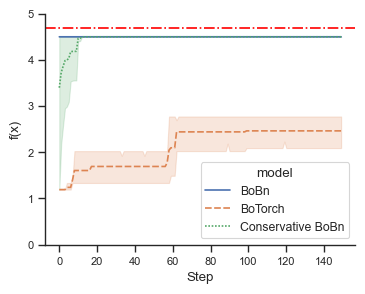

In [10]:
fig, ax = plt.subplots(figsize=(4, 3))

ax = sns.lineplot(data=all_results_df, x="step", y="best_f", hue="model", style='model', ax=ax)
ax.axhline(problem.optimal_value, ls='dashdot', label="Optimal value", color='red')
ax.set(xlabel="Step", ylabel="f(x)", ylim=(0, 5))
#
# output_location = "/home/salabed/workspace/latex/thesis/phd_dissertation/Chapters/BoBn/Figures"
# output_format = "svg"
# fig.savefig(f"{output_location}/decomposition_convergence.{output_format}", bbox_inches = "tight", format = f"{output_format}",
#           dpi = 300)
# output_format = "pdf"
# fig.savefig(f"{output_location}/decomposition_convergence.{output_format}", bbox_inches = "tight", format = f"{output_format}",
#           dpi = 300)

In [11]:
all_results_df.to_csv("bobn_exp_memory_results_df.csv")

In [15]:
all_results_df['peak_memory_mb'] = all_results_df['peak_memory'] / 1e6
all_results_df

,model,step,restart,candidate,result,best_f,steps_to_best_f,peak_memory,runtime_ms,peak_memory_mb
0,BoBn,0,0,"{'x5': 0.9965815271862424, 'x1': 2.20323125916...",4.495932,4.495932,0,152654848,14.052943,152.654848
1,BoBn,1,0,"{'x5': 0.9965818213766389, 'x1': 2.20324249419...",4.495838,4.495932,0,152152576,20.231353,152.152576
2,BoBn,2,0,"{'x5': 0.9965816808810518, 'x1': 2.20319585686...",4.495880,4.495932,0,154401280,17.888208,154.401280
3,BoBn,3,0,"{'x5': 0.9965819069565599, 'x1': 2.20319673092...",4.495867,4.495932,0,152711680,19.922008,152.711680
4,BoBn,4,0,"{'x5': 0.9965820979666967, 'x1': 2.20319755725...",4.495842,4.495932,0,153796608,12.771425,153.796608
...,...,...,...,...,...,...,...,...,...,...
1345,Conservative BoBn,145,2,"{'x5': 0.9965803069557791, 'x1': 2.20323408085...",4.495747,4.496183,140,148708352,6.254140,148.708352
1346,Conservative BoBn,146,2,"{'x5': 0.9965807038199104, 'x1': 2.20319098441...",4.495793,4.496183,140,149086720,8.097649,149.086720
1347,Conservative BoBn,147,2,"{'x5': 0.9965809423821623, 'x1': 2.20319168149...",4.495940,4.496183,140,151835136,6.160295,151.835136
1348,Conservative BoBn,148,2,"{'x5': 0.9965812950154049, 'x1': 2.20319259859...",4.495869,4.496183,140,150601728,12.509640,150.601728


findfont: Font family ['Arial'] not found. Falling back to Helvetica.
findfont: Font family ['Arial'] not found. Falling back to Helvetica.
findfont: Font family ['Arial'] not found. Falling back to Helvetica.


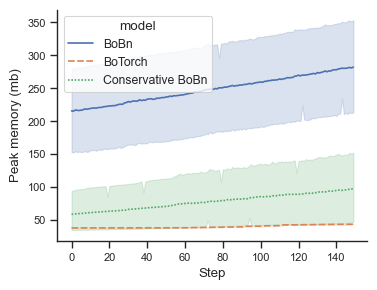

In [17]:
fig, ax = plt.subplots(figsize=(4, 3))

ax = sns.lineplot(data=all_results_df, x="step", y="peak_memory_mb", hue="model", style='model', ax=ax)
# ax.axhline(problem.optimal_value, ls='dashdot', label="Optimal value", color='red')
ax.set(xlabel="Step", ylabel="Peak memory (mb)")

output_location = "/home/salabed/workspace/latex/thesis/phd_dissertation/Chapters/BoBn/Figures"
output_format = "svg"
fig.savefig(f"{output_location}/memory_scaling.{output_format}", bbox_inches = "tight", format = f"{output_format}",
          dpi = 300)
output_format = "pdf"
fig.savefig(f"{output_location}/memory_scaling.{output_format}", bbox_inches = "tight", format = f"{output_format}",
          dpi = 300)

[Text(0.5, 0, 'Step'), Text(0, 0.5, 'Runtime (ms)')]

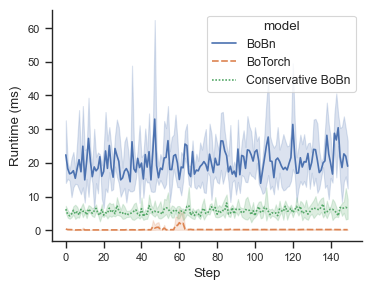

In [18]:
all_results_df
fig, ax = plt.subplots(figsize=(4, 3))

ax = sns.lineplot(data=all_results_df, x="step", y="runtime_ms", hue="model", style='model', ax=ax)
# ax.axhline(problem.optimal_value, ls='dashdot', label="Optimal value", color='red')
ax.set(xlabel="Step", ylabel="Runtime (ms)")
